In [154]:
# Step 1: Data Preprocessing
import pandas as pd
from tqdm import tqdm

# Read the xlsx file into a DataFrame
# Data from:
# https://nsidc.org/arcticseaicenews/sea-ice-tools/
# All daily (single day and five-day trailing average) extent values in one file, updated daily (Sea_Ice_Index_Daily_Extent_G02135_v3.0.xlsx)
file_path = 'Sea_Ice_Index_Daily_Extent_G02135_v3.0.xlsx'
df = pd.read_excel(file_path, engine='openpyxl', header=None)

# Extract the year values from the first column after removing non-numeric entries
years = df.iloc[0, 2:-3].dropna().astype(int).values

# Forward-fill missing month names with the previous non-NaN month value
df[0].fillna(method='ffill', inplace=True)

# make sure it has the right number of rows (1 + 366 = 367)
df = df.iloc[:367]

# Drop the first row (year header) and reset the index
df = df.iloc[1:].reset_index(drop=True)

# Drop the last three columns and reset the index
df = df.iloc[:, 0:-3].reset_index(drop=True)

# Preprocess the data for prophet package (ds and y columns)

# Initialize variables to hold month and day information
month = ''
day = ''

# Create a new DataFrame with the 'ds' and 'y' columns
df_new = pd.DataFrame(columns=['ds', 'y'])

df_new_row_index = 0

# Iterate through, column by column (skipping the first two)
for col_index in range(2, df.shape[1]):
    year = years[col_index - 2]
    print(f"Pre-processing data for year {year} ...")
    
    # Iterate through the DataFrame rows
    for index, row in df.iterrows():
        # If the row has a non-NaN value in the first column, it contains the month name
        if pd.notna(row[0]):
            month = row[0]
            day = int(row[1])
            
        # Check if the date falls on February 29 and if it is a non-leap year
        leap_year = (year % 4 == 0)
        if month == 'February' and day == 29 and not leap_year:
            # Skips this date since it is not a real date and there is no data
            continue

        # Construct the date string by combining month, day, and year information
        year_str = str(int(year))
        day_str = str(int(day))
        date_str = f"{month} {day_str}, {year_str}"

        # Add the constructed date strings as the 'ds' column in the DataFrame
        new_ds_value = pd.to_datetime(date_str, format='%B %d, %Y', errors='coerce')
        new_y_value = row[col_index]
        
        # Append the new 'ds' and 'y' values to the DataFrame
        df_new.loc[df_new_row_index, 'ds'] = new_ds_value
        df_new.loc[df_new_row_index, 'y'] = new_y_value
        df_new_row_index += 1
    
# Set any missing or empty values to NaN
df_new.replace(r'^\s*$', pd.NA, regex=True, inplace=True)

Pre-processing data for year 1978 ...
Pre-processing data for year 1979 ...
Pre-processing data for year 1980 ...
Pre-processing data for year 1981 ...
Pre-processing data for year 1982 ...
Pre-processing data for year 1983 ...
Pre-processing data for year 1984 ...
Pre-processing data for year 1985 ...
Pre-processing data for year 1986 ...
Pre-processing data for year 1987 ...
Pre-processing data for year 1988 ...
Pre-processing data for year 1989 ...
Pre-processing data for year 1990 ...
Pre-processing data for year 1991 ...
Pre-processing data for year 1992 ...
Pre-processing data for year 1993 ...
Pre-processing data for year 1994 ...
Pre-processing data for year 1995 ...
Pre-processing data for year 1996 ...
Pre-processing data for year 1997 ...
Pre-processing data for year 1998 ...
Pre-processing data for year 1999 ...
Pre-processing data for year 2000 ...
Pre-processing data for year 2001 ...
Pre-processing data for year 2002 ...
Pre-processing data for year 2003 ...
Pre-processi

In [155]:
# Remove empty values from future dates at end of the frame
# Find the index of the last non-empty 'y' value starting from the last row
last_non_empty_y_index = None
for i in range(len(df_new) - 1, -1, -1):
    if pd.notna(df_new.loc[i, 'y']):
        last_non_empty_y_index = i
        break

# If no non-empty 'y' value is found, the DataFrame will be empty
if last_non_empty_y_index is not None:
    # Slice the DataFrame to keep rows from last_non_empty_y_index onwards
    df_new = df_new.loc[0:last_non_empty_y_index]

print('Done pre-processing data:')
print(df_new)


Done pre-processing data:
              ds      y
0     1978-01-01    NaN
1     1978-01-02    NaN
2     1978-01-03    NaN
3     1978-01-04    NaN
4     1978-01-05    NaN
...          ...    ...
16679 2023-09-01  4.573
16680 2023-09-02  4.538
16681 2023-09-03  4.483
16682 2023-09-04  4.450
16683 2023-09-05  4.409

[16684 rows x 2 columns]


In [156]:
# optional linear interpolation (never used)
num_missing_values = df_new['y'].isna().sum()

print("Number of missing values in 'y' column:", num_missing_values)

df_interp = df_new.copy()

# Perform linear interpolation for missing values in the 'y' column
df_interp['y'] = df_interp['y'].interpolate(method='linear', axis=0, limit_area='inside', limit_direction='both')

num_missing_values = df_interp['y'].isna().sum()

print("Number of missing values in 'y' column:", num_missing_values)


Number of missing values in 'y' column: 1949
Number of missing values in 'y' column: 298


In [157]:
# Step 2: Install and Import Required Libraries
# You might need to install fbprophet using "pip install fbprophet" first.
from prophet import Prophet

def doForecast(df_historical, period):
    # Step 3: Forecasting with Prophet
    # Create a Prophet model
    model = Prophet(interval_width=0.995, seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    
    # Fit the model to your data
    model.fit(df_historical)

    # Create a DataFrame with future dates for prediction
    future_dates = model.make_future_dataframe(periods=period, include_history=False)  # Forecasting 365 days into the future

    # Make predictions for the future dates
    forecast = model.predict(future_dates)
    return forecast, model

def doForecastWithParams(df_historical, period, changepoint_prior_scale, seasonality_prior_scale, change_dates = None):
    # Step 3: Forecasting with Prophet
    # Create a Prophet model
    model = Prophet(interval_width=0.995, changepoints=change_dates, changepoint_prior_scale=changepoint_prior_scale, seasonality_prior_scale=seasonality_prior_scale, seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    
    # Fit the model to your data
    model.fit(df_historical)

    # Create a DataFrame with future dates for prediction
    future_dates = model.make_future_dataframe(periods=period, include_history=False)  # Forecasting 365 days into the future

    # Make predictions for the future dates
    forecast = model.predict(future_dates)
    return forecast, model

def doForecastCross(df_historical, periods, params, change_dates = None):
    # Step 3: Forecasting with Prophet
    # Create a Prophet model
    # Adjusted hyper-parameter changepoint_prior_scale:
    # initial tuning suggests 0.5, 10 but this only gets the minimum and increases the error farther out for the max
    model = Prophet(interval_width=0.995, changepoints=change_dates, seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, **params)
    
    # Fit the model to your data
    model.fit(df_historical)

    # Create a DataFrame with future dates for prediction
    future_dates = model.make_future_dataframe(periods=period, include_history=False)  # Forecasting 365 days into the future

    # Make predictions for the future dates
    forecast = model.predict(future_dates)
    return forecast, model

In [186]:
# Do forecast for current year, for graph
# Period of days into the future to forecast
# For this graph we will use a whole year into the future to forecast
# Need to adjust the period down as we get near the minimum (mid-September)
#   in order to make sure we only calculate the minimum for this year
period = 120

# Without any tuning
#[forecast, model] = doForecast(df_new, period)

# With tuning from cross-validation

cutoff_date_timestamp = df_new['ds'].iloc[-1]
min_max_dates = ['1979-09-21', '1980-09-05', '1981-09-10', '1982-09-13', '1983-09-08', '1984-09-16', '1985-09-09', '1986-09-06', '1987-09-02', '1988-09-11', '1989-09-22', '1990-09-21', '1991-09-16', '1992-09-07', '1993-09-13', '1994-09-05', '1995-09-04', '1996-09-10', '1997-09-03', '1998-09-17', '1999-09-12', '2000-09-11', '2001-09-19', '2002-09-18', '2003-09-17', '2004-09-18', '2005-09-20', '2006-09-14', '2007-09-14', '2008-09-18', '2009-09-12', '2010-09-19', '2011-09-08', '2012-09-16', '2013-09-13', '2014-09-16', '2015-09-08', '2016-09-07', '2017-09-13', '2018-09-21', '2019-09-18', '2020-09-13', '2021-09-14', '2022-09-15', '1979-03-01', '1980-03-05', '1981-03-14', '1982-02-26', '1983-03-14', '1984-03-18', '1985-03-17', '1986-03-10', '1987-02-20', '1988-03-10', '1989-03-06', '1990-03-12', '1991-02-24', '1992-03-12', '1993-03-13', '1994-02-20', '1995-03-31', '1996-02-21', '1997-03-20', '1998-02-24', '1999-03-30', '2000-03-03', '2001-03-04', '2002-03-09', '2003-03-20', '2004-03-10', '2005-03-09', '2006-03-11', '2007-03-10', '2008-02-27', '2009-03-02', '2010-03-31', '2011-03-07', '2012-03-18', '2013-03-14', '2014-03-20', '2015-02-21', '2016-03-22', '2017-03-05', '2018-03-14', '2019-03-11', '2020-03-04', '2021-03-11', '2022-02-20', '2023-03-05']
# Convert the list of date strings to pandas Timestamp objects
timestamps = pd.to_datetime(min_max_dates)
# Filter the timestamps to include only dates before the cutoff_date
cutoff_change_dates = timestamps[timestamps <= cutoff_date_timestamp]
# Sort the Timestamps in increasing order
cutoff_change_dates = cutoff_change_dates.sort_values()
# Convert the filtered timestamps back to date strings
cutoff_change_dates_strings = cutoff_change_dates.strftime('%Y-%m-%d').tolist()

# see cross validation xlsx
# for 7-21 to 8-21: keep trend tight, and no regularization penalty for seasonality
# validation with tuning from cross-validation
changepoint_prior_scale = 0.001
seasonality_prior_scale = 10
[forecast, model] = doForecastWithParams(df_new, period, changepoint_prior_scale, seasonality_prior_scale, cutoff_change_dates_strings)

# Print the forecasted values
print("Forecast DataFrame:")
print(forecast)

10:35:12 - cmdstanpy - INFO - Chain [1] start processing
10:35:17 - cmdstanpy - INFO - Chain [1] done processing


Forecast DataFrame:
            ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2023-09-06  10.396597    3.646091    6.044191    10.396597    10.396598   
1   2023-09-07  10.396600    3.657037    5.901597    10.396599    10.396602   
2   2023-09-08  10.396602    3.697967    6.010335    10.396599    10.396608   
3   2023-09-09  10.396604    3.615156    6.023067    10.396598    10.396614   
4   2023-09-10  10.396606    3.790155    5.980683    10.396595    10.396620   
..         ...        ...         ...         ...          ...          ...   
115 2023-12-30  10.396861   11.415713   13.627958    10.395579    10.398234   
116 2023-12-31  10.396864   11.352744   13.753523    10.395568    10.398251   
117 2024-01-01  10.396866   11.444426   13.646358    10.395556    10.398268   
118 2024-01-02  10.396868   11.425220   13.807780    10.395545    10.398284   
119 2024-01-03  10.396870   11.414793   13.825881    10.395533    10.398301   

     additive_terms  additive_t

In [187]:
# Current year forecast graph 
import pandas as pd
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly

#pip install ipywidgets

# Assuming you have the forecast data in a DataFrame called forecast_df
forecast_df = forecast.loc[-365:]
# The DataFrame should contain a 'ds' column with the dates and a 'yhat' column with the forecasted values.

# Convert the 'ds' column to pandas datetime objects (if not already)
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])

# Plot the forecast using plot_plotly
fig = plot_plotly(model, forecast_df)
# Set the default range for the x-axis (datetimestamp)
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-10-31')
fig.update_xaxes(range=[start_date, end_date])
fig.update_yaxes(range=[3.5, 5])  
fig.update_layout(title_text="Arctic Sea Ice-Extent Forecast only using historical data)")
fig.update_yaxes(title_text="Extent (10^6 km^2)")
fig.show()

# Plot the forecast components using plot_components_plotly
fig_comp = plot_components_plotly(model, forecast_df)
fig_comp.show()

In [160]:
# Calculate the current year forecast minimum values

forecasted_values = forecast['yhat']
forecasted_lower_bounds = forecast['yhat_lower']
forecasted_upper_bounds = forecast['yhat_upper']

# Print the minimum value for the forecast
min_forecast = forecasted_values.min()
print("Minimum Forecast Value:", round(min_forecast, 3))

# Print the ± range values for the forecast
print("Lower Bound:", round(forecasted_lower_bounds.min(),3))
print("Upper Bound:", round(forecasted_upper_bounds.min(),3))


Minimum Forecast Value: 4.843
Lower Bound: 3.618
Upper Bound: 5.852


In [161]:
# Repeat runs and check if any bounds contain threshold, also compute min and adjusted min counts
threshold = 3.41
# run count
numruns = 5
# limit number of days for speed?
# period = 120
mins = []
adj_mins = []

threshold_in_range_count = 0
print(f"Check to see if threshold record for minimum ({threshold}) is in range of 99.5% interval for forecast for {numruns} runs")
for i in range(numruns):
    #[forecast_run, model_run] = doForecast(df_new, period)
    [forecast_run, model_run] = doForecastWithParams(df_new, period, changepoint_prior_scale, seasonality_prior_scale, cutoff_change_dates_strings)
    forecasted_lower_bounds = forecast_run['yhat_lower'].min()
    forecasted_upper_bounds = forecast_run['yhat_upper'].min()
    forecasted_values = forecast_run['yhat']
    min_forecast = forecast_run['yhat'].min()
    print(min_forecast)
    threshold_in_range = (forecasted_lower_bounds <= threshold) and (threshold <= forecasted_upper_bounds)

    # compute min and adjusted min
    forecasted_values = forecast_run['yhat']
    first_forecast = forecasted_values[0]
    second_forecast = forecasted_values[1]
    last_obs = df_interp['y'].iloc[-1]
    second_last_obs = df_interp['y'].iloc[-2]
    pred_first_by_obs = last_obs - abs(second_last_obs - last_obs)
    pred_first_by_forecast = last_obs - abs(first_forecast - second_forecast)
    offset_by_obs = first_forecast - pred_first_by_obs
    offset_by_forecast = first_forecast - pred_first_by_forecast
    offset_avg = (offset_by_obs + offset_by_forecast) / 2
    adj_min = min_forecast - offset_avg
    print(f"Min forecast: {min_forecast}")
    print(f"Adjusted min forecast by offset avg: {adj_min:1.3f}")
    mins.append(min_forecast)
    adj_mins.append(adj_min)
    
    print(f"Run {i+1}")
    if threshold_in_range:
        print("Threshold in range!")
        threshold_in_range_count += 1
        print(" Minimum Forecast Value:", round(min_forecast, 3))
        # Print the ± range values for the forecast
        print("  99.5% Interval:")
        print("    Lower Bound:", round(forecasted_lower_bounds,3))
        print("    Upper Bound:", round(forecasted_upper_bounds,3))

pct_threshold_in_range = round(100 * threshold_in_range_count / numruns , 3)
print(f"Forecast has record minimum in range for {pct_threshold_in_range} % of the runs ({threshold_in_range_count} / {numruns})")


Check to see if threshold record for minimum (3.41) is in range of 99.5% interval for forecast for 5 runs


08:19:33 - cmdstanpy - INFO - Chain [1] start processing
08:19:37 - cmdstanpy - INFO - Chain [1] done processing


4.842553943487551
Min forecast: 4.842553943487551
Adjusted min forecast by offset avg: 4.313
Run 1


08:19:38 - cmdstanpy - INFO - Chain [1] start processing
08:19:42 - cmdstanpy - INFO - Chain [1] done processing


4.842553943487551
Min forecast: 4.842553943487551
Adjusted min forecast by offset avg: 4.313
Run 2


08:19:44 - cmdstanpy - INFO - Chain [1] start processing
08:19:47 - cmdstanpy - INFO - Chain [1] done processing


4.842553943487551
Min forecast: 4.842553943487551
Adjusted min forecast by offset avg: 4.313
Run 3


08:19:49 - cmdstanpy - INFO - Chain [1] start processing
08:19:53 - cmdstanpy - INFO - Chain [1] done processing


4.842553943487551
Min forecast: 4.842553943487551
Adjusted min forecast by offset avg: 4.313
Run 4


08:19:54 - cmdstanpy - INFO - Chain [1] start processing
08:19:58 - cmdstanpy - INFO - Chain [1] done processing


4.842553943487551
Min forecast: 4.842553943487551
Adjusted min forecast by offset avg: 4.313
Run 5
Forecast has record minimum in range for 0.0 % of the runs (0 / 5)


In [162]:
above5000 = 0
above4750 = 0
above4500 = 0
above4250 = 0
above4000 = 0
below4000 = 0
total = 0

for min in adj_mins:
    above5000 += (min >= 5.000)
    above4750 += (4.75 <= min <= 4.999)
    above4500 += (4.5 <= min <= 4.749)
    above4250 += (4.25 <= min <= 4.499)
    above4000 += (4.0 <= min <= 4.249)
    below4000 += (min < 4.0)
    total += 1

print("Adjusted min frequencies:")
print(f">= 5:           {above5000/total:3.1f}")
print(f"4.750 - 4.999:  {above4750/total:3.1f}")
print(f"4.500 - 4.749:  {above4500/total:3.1f}")
print(f"4.250 - 4.499:  {above4250/total:3.1f}")
print(f"4.000 - 4.249:  {above4000/total:3.1f}")
print(f"< 4:            {below4000/total:3.1f}")

Adjusted min frequencies:
>= 5:           0.0
4.750 - 4.999:  0.0
4.500 - 4.749:  0.0
4.250 - 4.499:  1.0
4.000 - 4.249:  0.0
< 4:            0.0


In [163]:

# manual interpolation
# assuming:
#    0.05 drop from last observation
#    estimating the predicted minimum is off by the difference between the last observation and the first prediction
4.832 - (5.252 - (4.884 - .05))


4.414000000000001

In [164]:
4.842 - (5.141986 - (4.781 - (4.85 - 4.781)))

4.412013999999999

In [165]:
4.842 - (5.141986 - (4.781 - (5.141986 - 5.105938)))

4.444965999999999

In [166]:
first_forecast = forecasted_values[0]
second_forecast = forecasted_values[1]
last_obs = df_interp['y'].iloc[-1]
second_last_obs = df_interp['y'].iloc[-2]
pred_first_by_obs = last_obs - abs(second_last_obs - last_obs)
pred_first_by_forecast = last_obs - abs(first_forecast - second_forecast)
offset_by_obs = first_forecast - pred_first_by_obs
offset_by_forecast = first_forecast - pred_first_by_forecast
offset_avg = (offset_by_obs + offset_by_forecast) / 2
adj_min = min_forecast - offset_avg
print(f"Min forecast: {min_forecast}")
print(f"Adjusted min forecast by offset avg {-offset_avg}: {adj_min}")
adj_diff_from_last = last_obs - adj_min
print(f"Adjusted min forecast diff from last obs: {adj_diff_from_last}")
last_obs_date = df_interp['ds'].iloc[-1]

Min forecast: 4.842553943487551
Adjusted min forecast by offset avg -0.5297367758036642: 4.312817167683887
Adjusted min forecast diff from last obs: 0.09618283231611269


In [167]:
min_dates = ['1979-09-21', '1980-09-05', '1981-09-10', '1982-09-13', '1983-09-08', '1984-09-16', '1985-09-09', '1986-09-06', '1987-09-02', '1988-09-11', '1989-09-22', '1990-09-21', '1991-09-16', '1992-09-07', '1993-09-13', '1994-09-05', '1995-09-04', '1996-09-10', '1997-09-03', '1998-09-17', '1999-09-12', '2000-09-11', '2001-09-19', '2002-09-18', '2003-09-17', '2004-09-18', '2005-09-20', '2006-09-14', '2007-09-14', '2008-09-18', '2009-09-12', '2010-09-19', '2011-09-08', '2012-09-16', '2013-09-13', '2014-09-16', '2015-09-08', '2016-09-07', '2017-09-13', '2018-09-21', '2019-09-18', '2020-09-13', '2021-09-14', '2022-09-15']

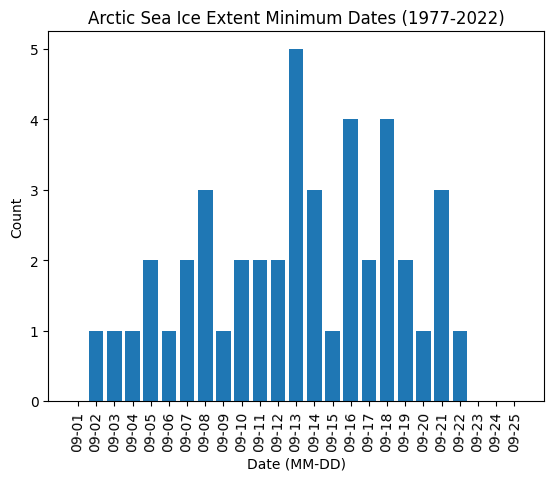

In [168]:
import matplotlib.pyplot as plt
from datetime import datetime


# Create a list of all possible days in September
all_days_of_september = [f'09-{day:02d}' for day in range(1, 26)]

# Step 1: Convert date strings to datetime objects
date_objects = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in min_dates]

# Step 2: Extract the month and day components from datetime objects
date_labels = [date_obj.strftime('%m-%d') for date_obj in date_objects]

# Count the occurrences of each date
date_counts = {}
for label in date_labels:
    date_counts[label] = date_counts.get(label, 0) + 1

# Initialize counts for all days of September, including zeros
counts_for_all_days = [date_counts.get(day, 0) for day in all_days_of_september]

# Step 3: Create a bar chart
plt.bar(all_days_of_september, counts_for_all_days)
plt.xlabel('Date (MM-DD)')
plt.ylabel('Count')
plt.title('Arctic Sea Ice Extent Minimum Dates (1977-2022)')
plt.xticks(rotation=88)  # Rotate x-axis labels for better readability
plt.yticks(range(max(counts_for_all_days) + 1))  # Set y-axis ticks to integers
plt.show()


In [169]:
print(type(df_interp.iloc[628]['ds']))
print(df_interp.iloc[628]['ds'])
#print(df_interp.at[df_interp.iloc[263]['ds'],'y'])
result = df_interp[df_interp['ds'] == df_interp.iloc[628]['ds']]
if not result.empty:
    y_value = result.iloc[0]['y']
    print(y_value)

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
1979-09-21 00:00:00
6.895


39 years (min year: 1979)
       > 4.25   : 51.28%  (20)
  4.0 to 4.2499 : 46.15%  (18)
       < 4.0    : 2.56%   (1)


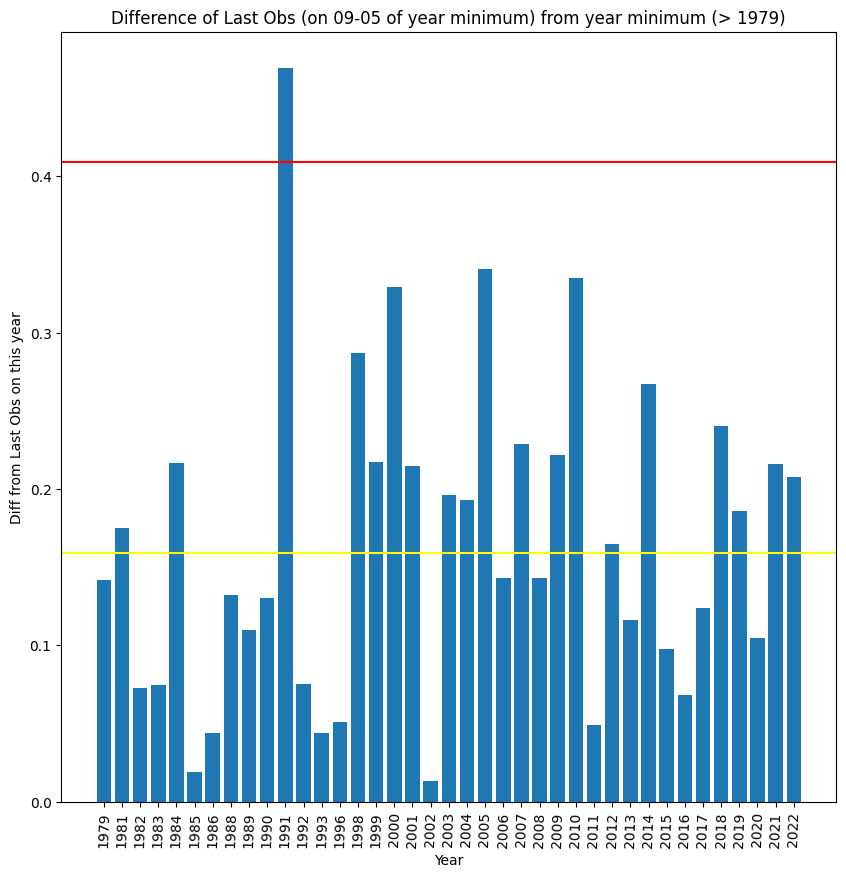

38 years (min year: 1980)
       > 4.25   : 50.00%  (19)
  4.0 to 4.2499 : 47.37%  (18)
       < 4.0    : 2.63%   (1)


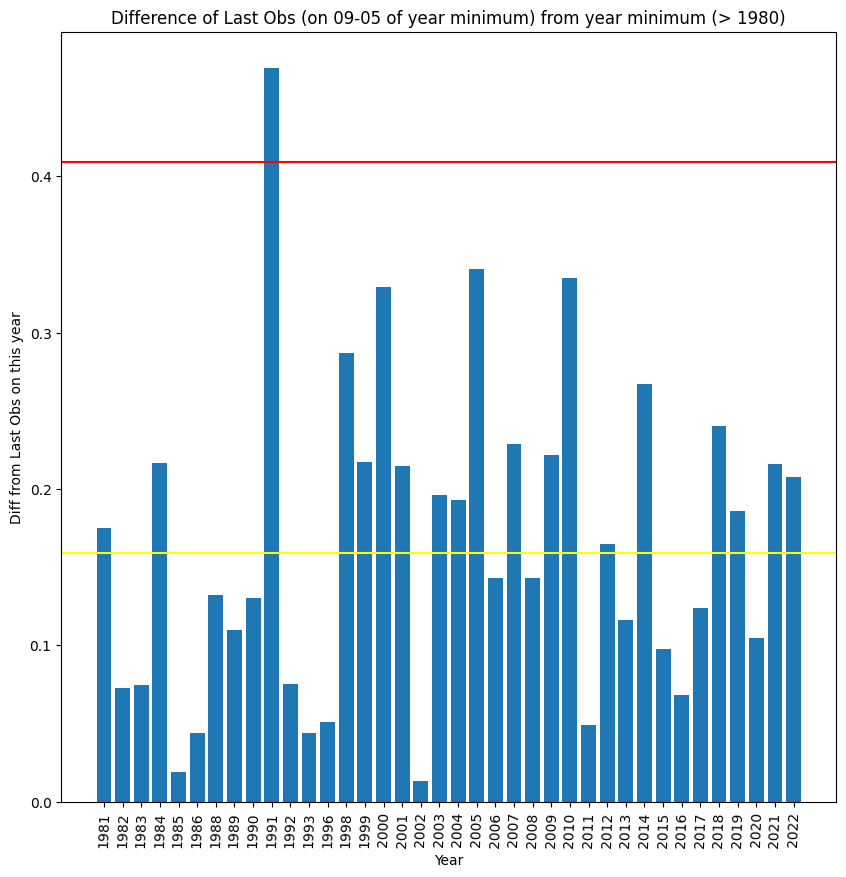

38 years (min year: 1981)
       > 4.25   : 50.00%  (19)
  4.0 to 4.2499 : 47.37%  (18)
       < 4.0    : 2.63%   (1)


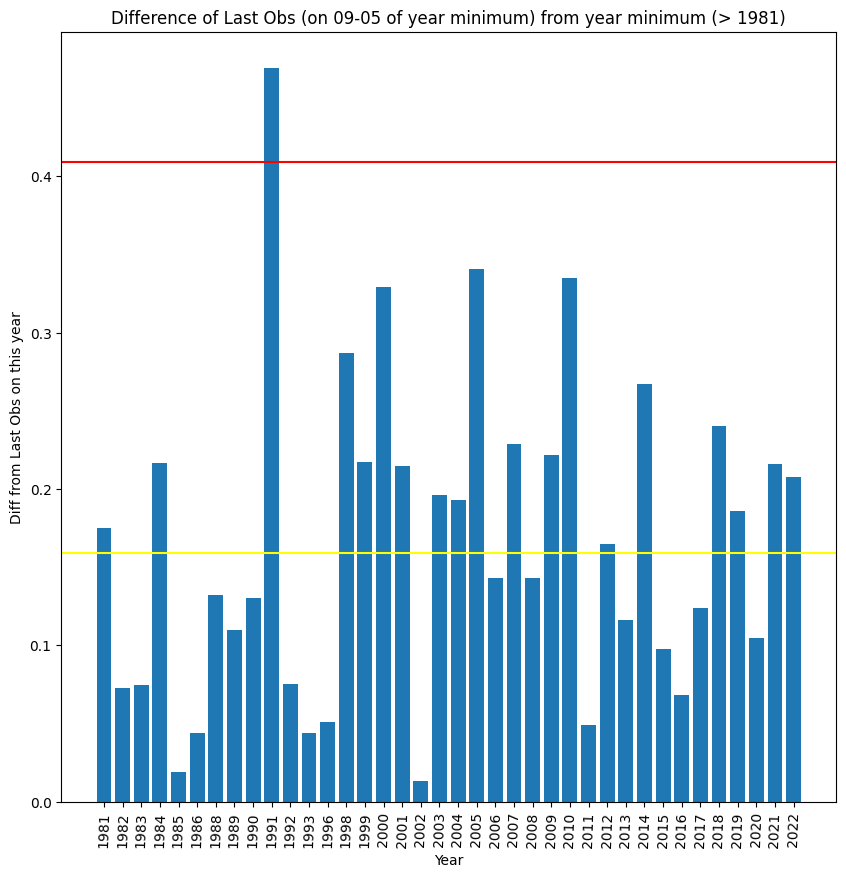

37 years (min year: 1982)
       > 4.25   : 51.35%  (19)
  4.0 to 4.2499 : 45.95%  (17)
       < 4.0    : 2.70%   (1)


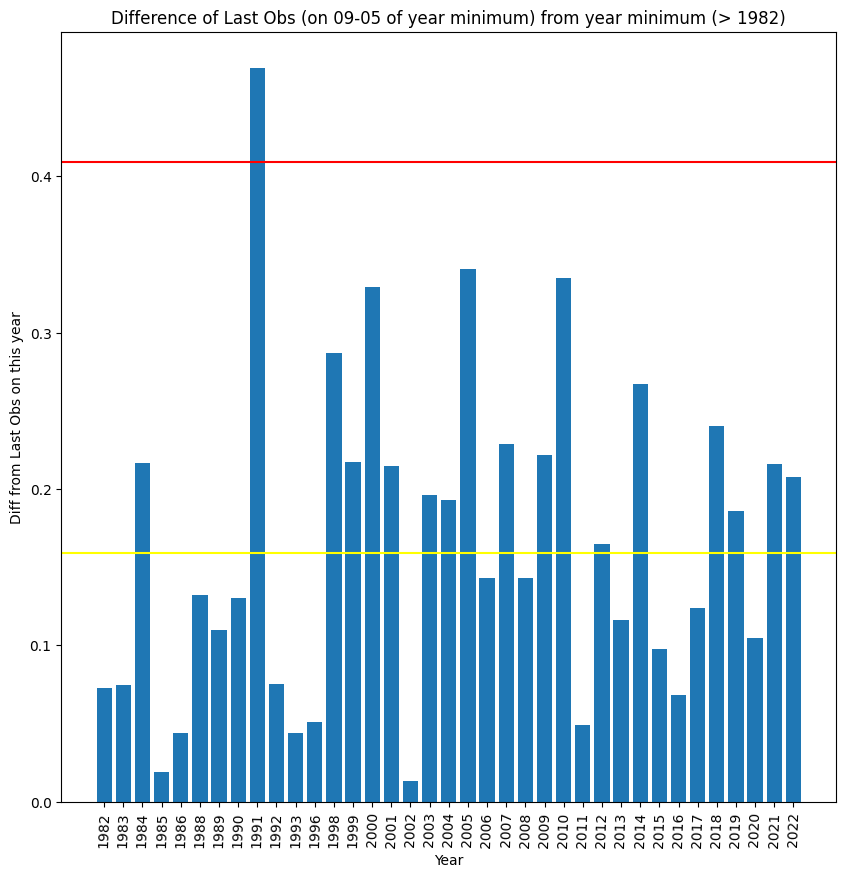

36 years (min year: 1983)
       > 4.25   : 50.00%  (18)
  4.0 to 4.2499 : 47.22%  (17)
       < 4.0    : 2.78%   (1)


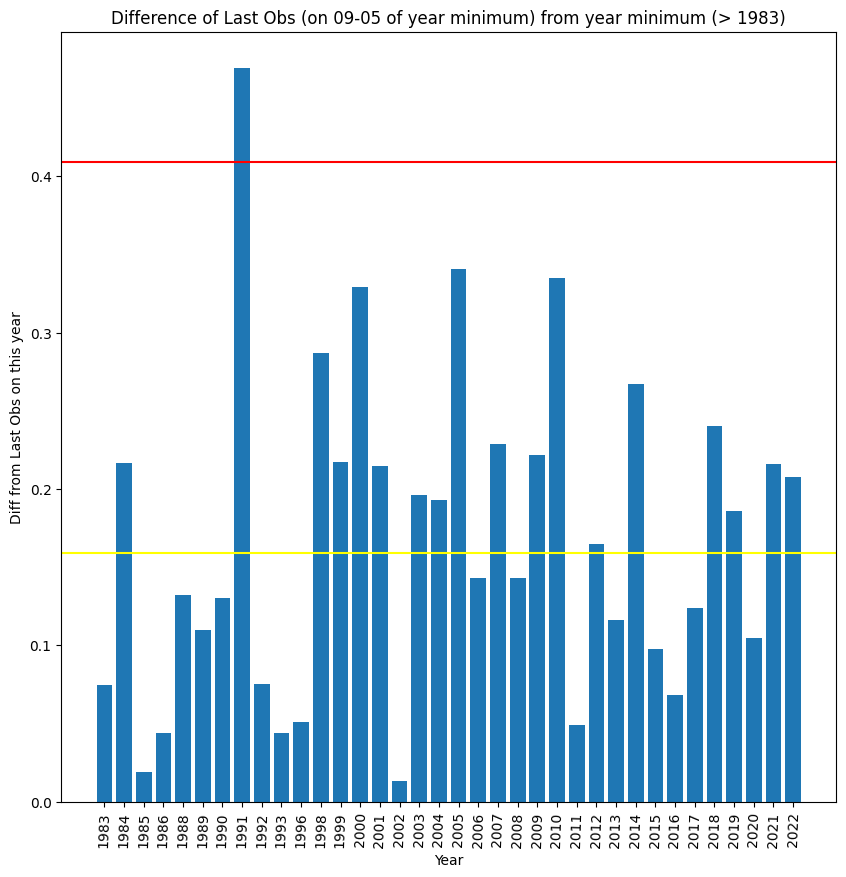

35 years (min year: 1984)
       > 4.25   : 48.57%  (17)
  4.0 to 4.2499 : 48.57%  (17)
       < 4.0    : 2.86%   (1)


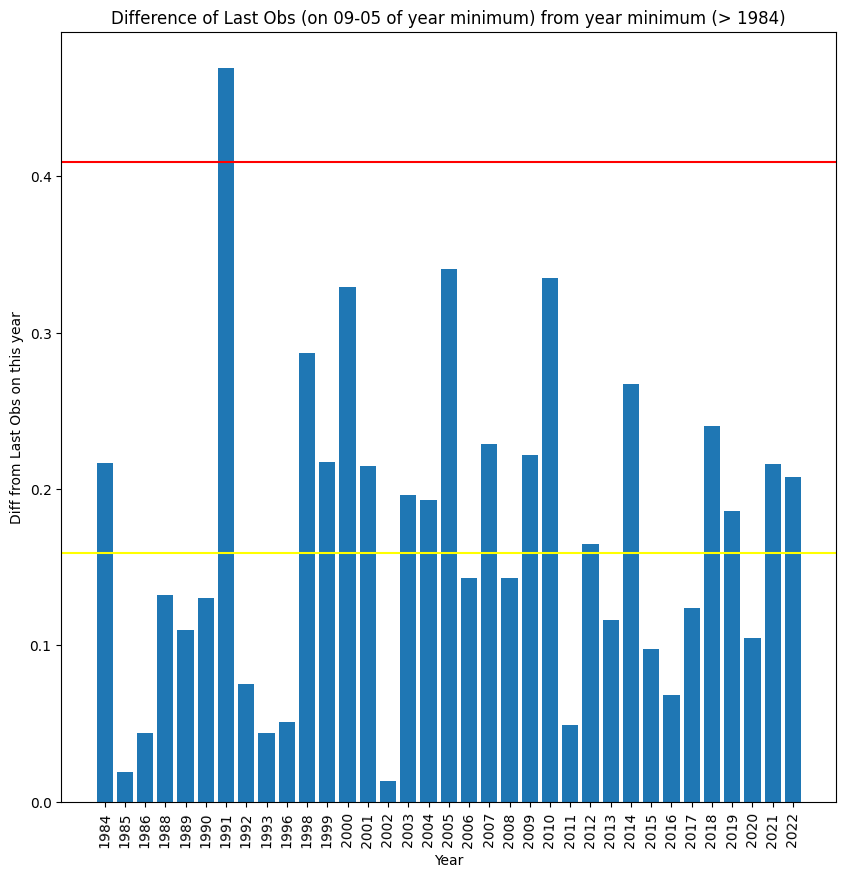

34 years (min year: 1985)
       > 4.25   : 50.00%  (17)
  4.0 to 4.2499 : 47.06%  (16)
       < 4.0    : 2.94%   (1)


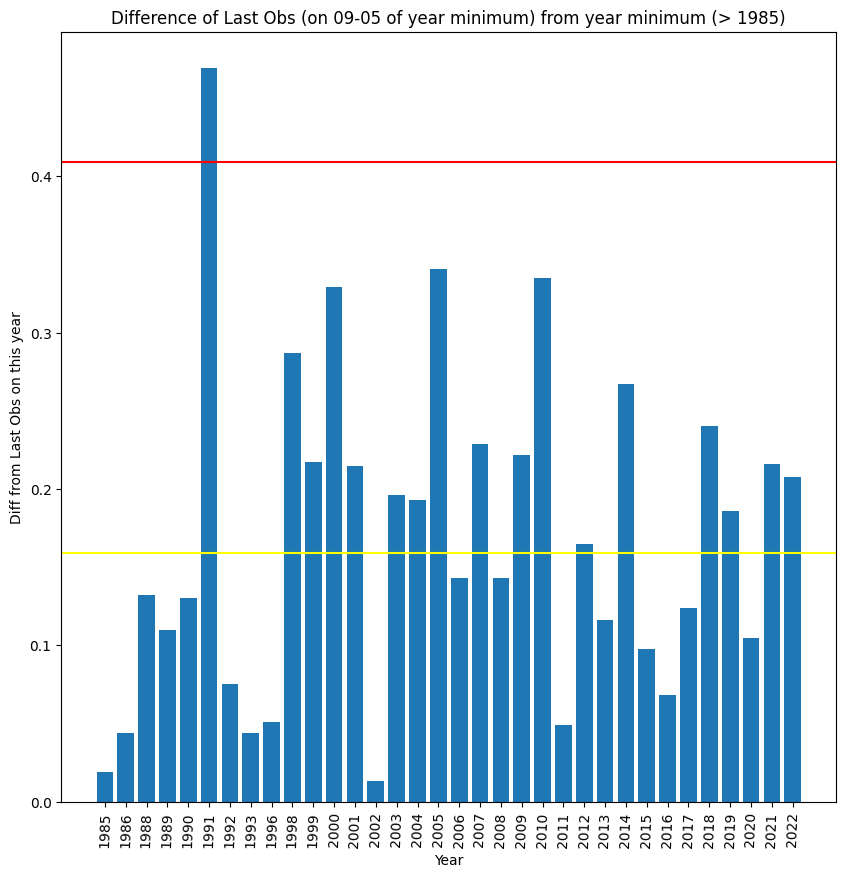

33 years (min year: 1986)
       > 4.25   : 48.48%  (16)
  4.0 to 4.2499 : 48.48%  (16)
       < 4.0    : 3.03%   (1)


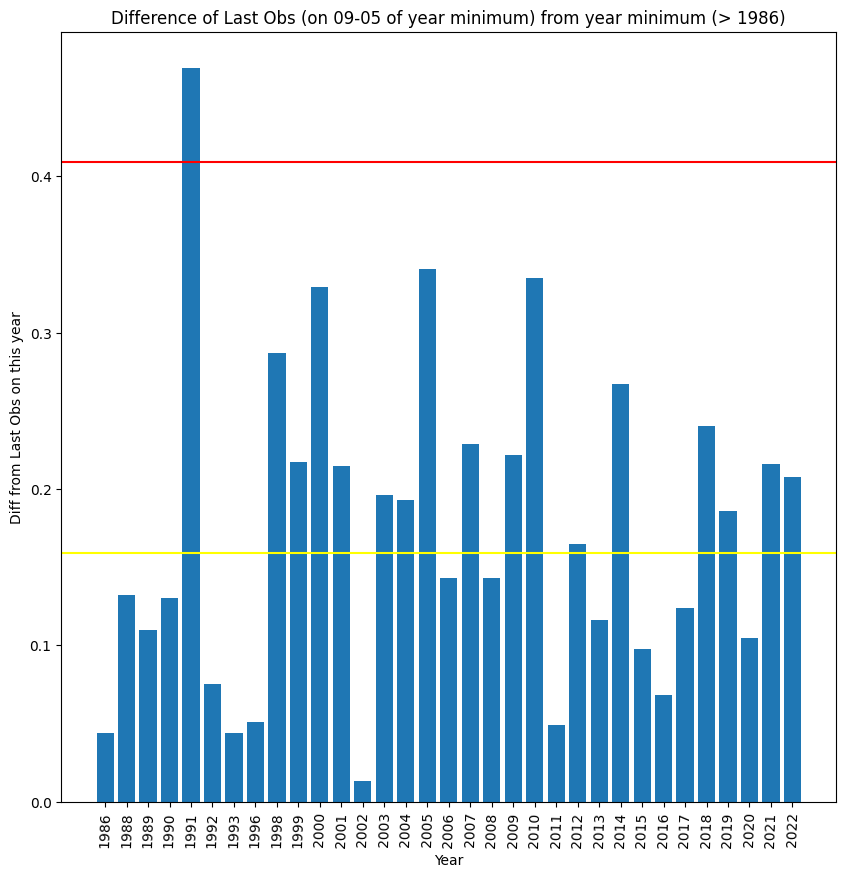

32 years (min year: 1987)
       > 4.25   : 46.88%  (15)
  4.0 to 4.2499 : 50.00%  (16)
       < 4.0    : 3.12%   (1)


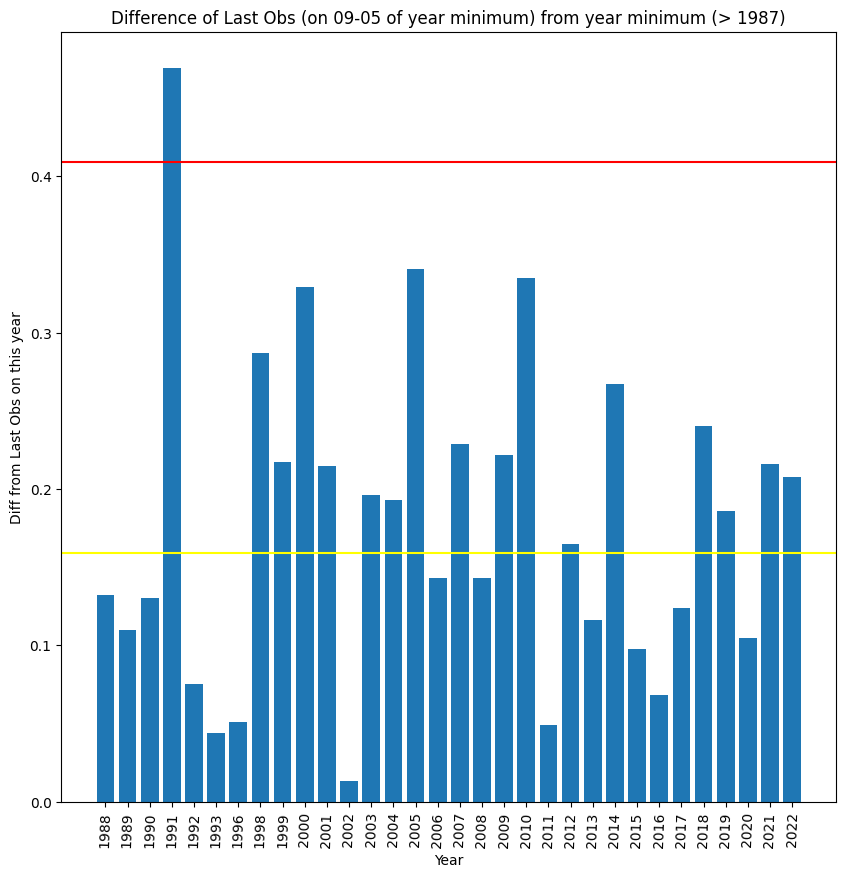

32 years (min year: 1988)
       > 4.25   : 46.88%  (15)
  4.0 to 4.2499 : 50.00%  (16)
       < 4.0    : 3.12%   (1)


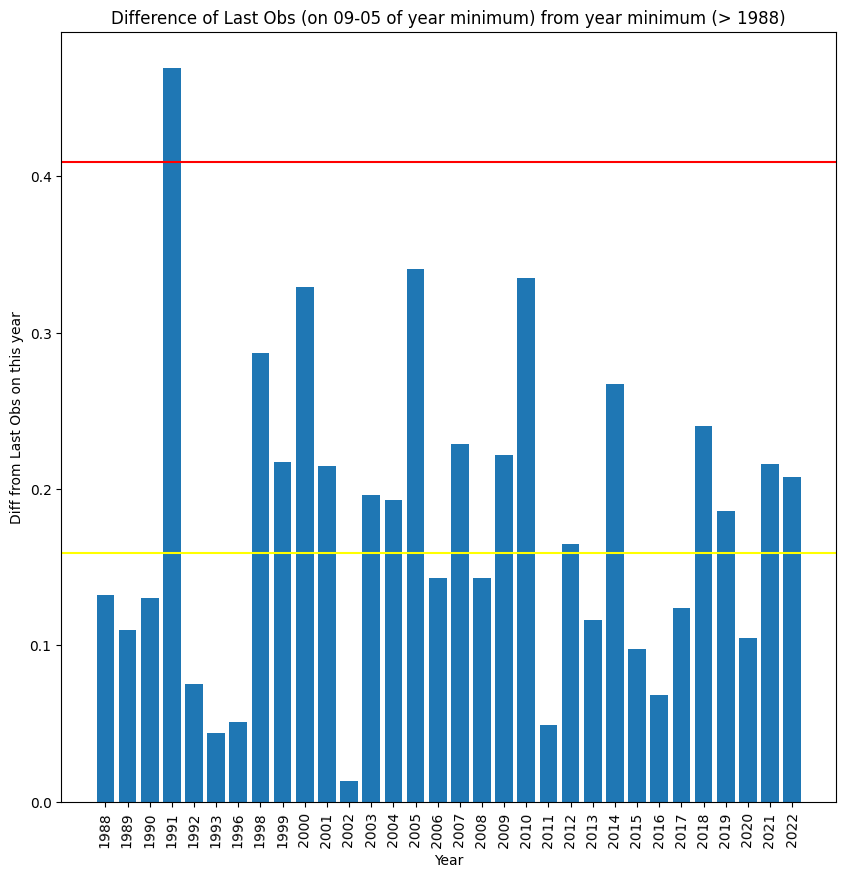

31 years (min year: 1989)
       > 4.25   : 45.16%  (14)
  4.0 to 4.2499 : 51.61%  (16)
       < 4.0    : 3.23%   (1)


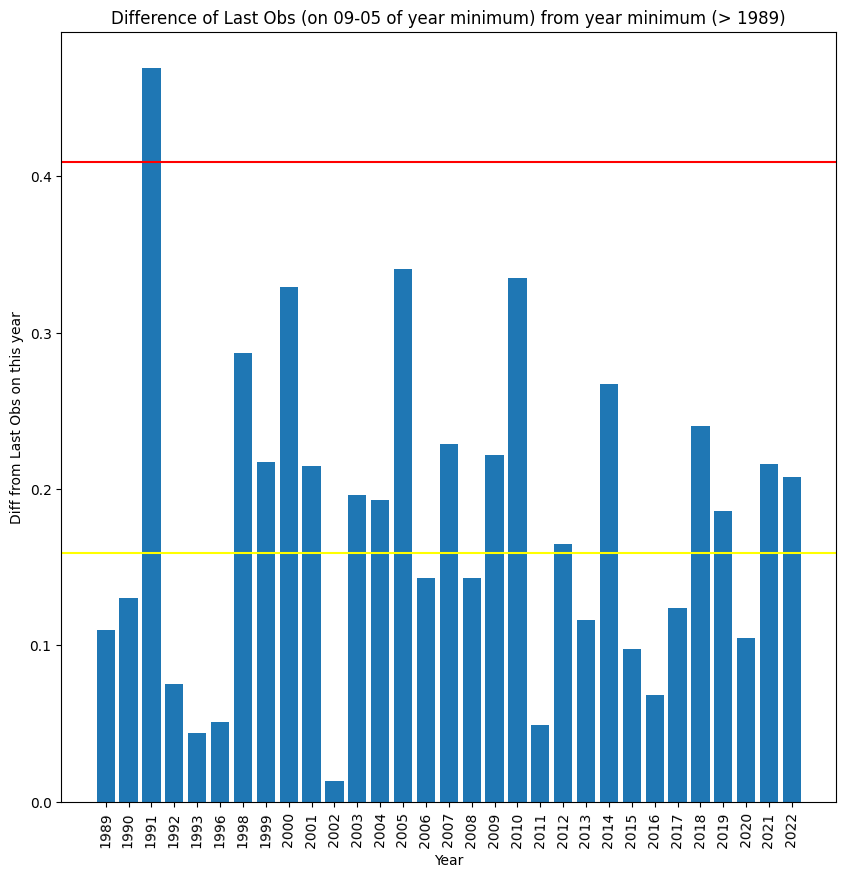

30 years (min year: 1990)
       > 4.25   : 43.33%  (13)
  4.0 to 4.2499 : 53.33%  (16)
       < 4.0    : 3.33%   (1)


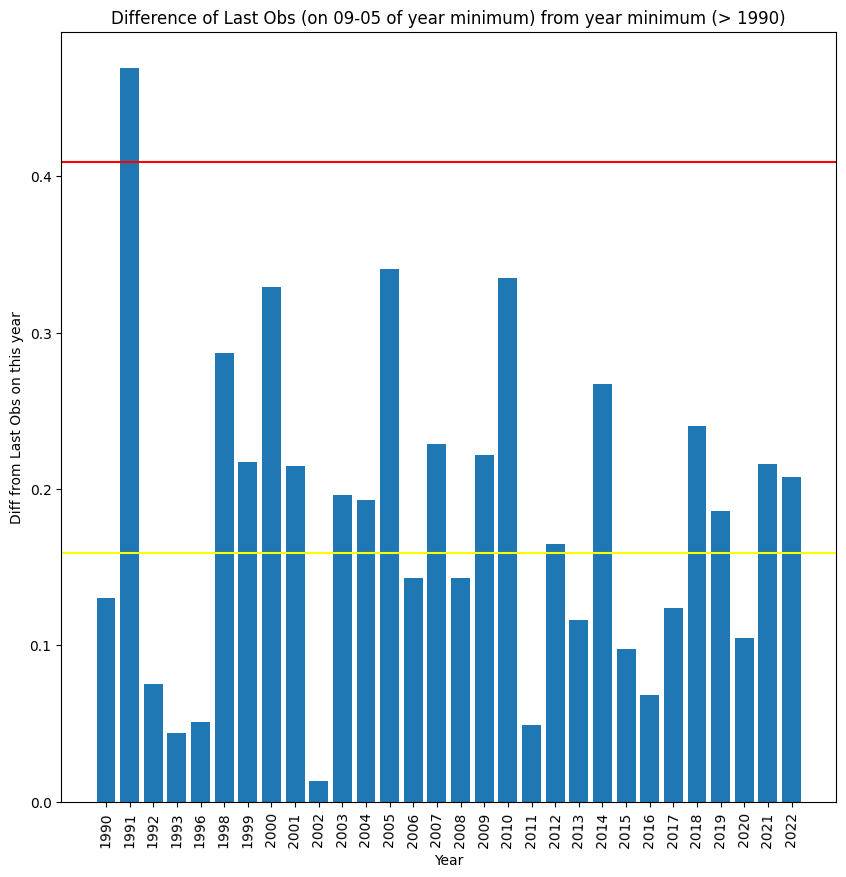

29 years (min year: 1991)
       > 4.25   : 41.38%  (12)
  4.0 to 4.2499 : 55.17%  (16)
       < 4.0    : 3.45%   (1)


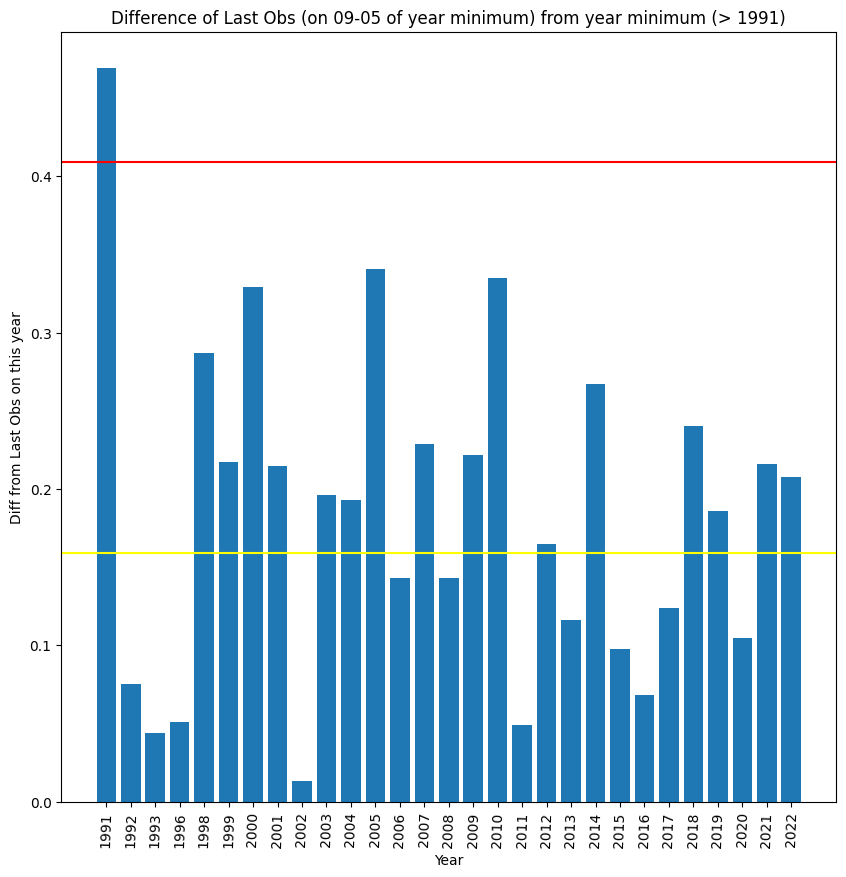

28 years (min year: 1992)
       > 4.25   : 42.86%  (12)
  4.0 to 4.2499 : 57.14%  (16)
       < 4.0    : 0.00%   (0)


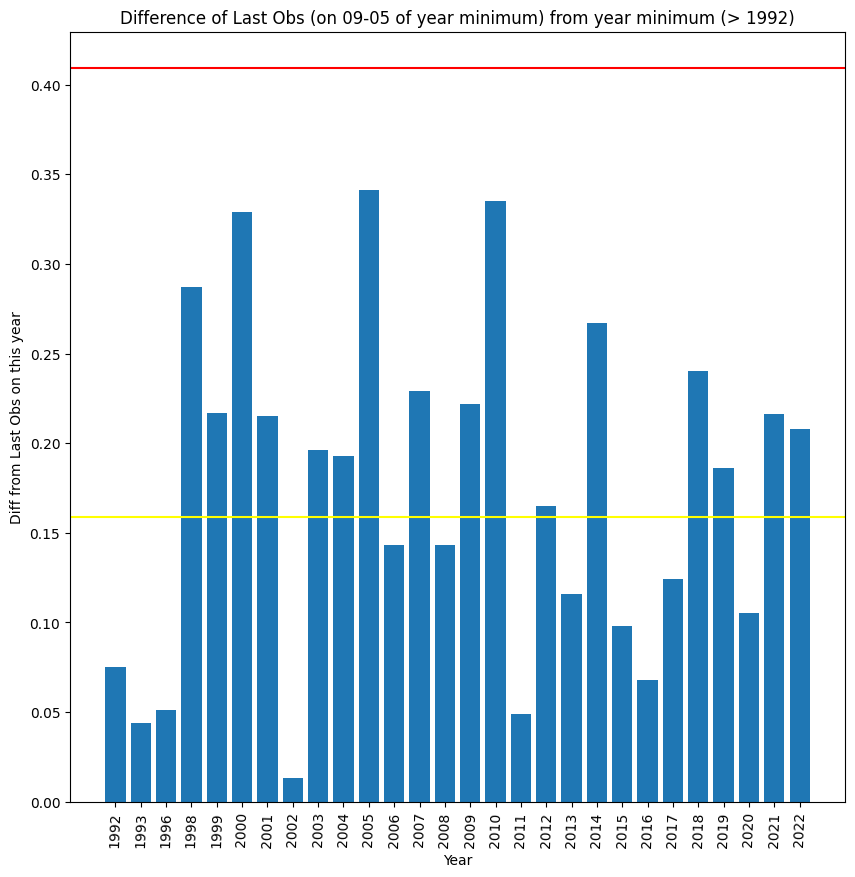

27 years (min year: 1993)
       > 4.25   : 40.74%  (11)
  4.0 to 4.2499 : 59.26%  (16)
       < 4.0    : 0.00%   (0)


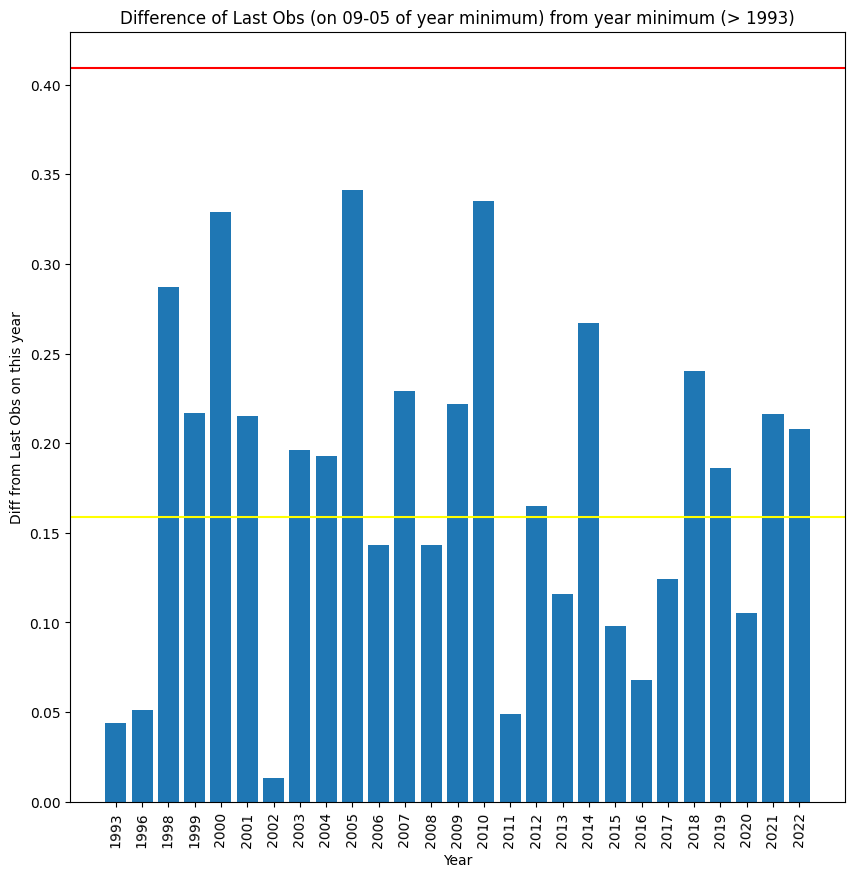

26 years (min year: 1994)
       > 4.25   : 38.46%  (10)
  4.0 to 4.2499 : 61.54%  (16)
       < 4.0    : 0.00%   (0)


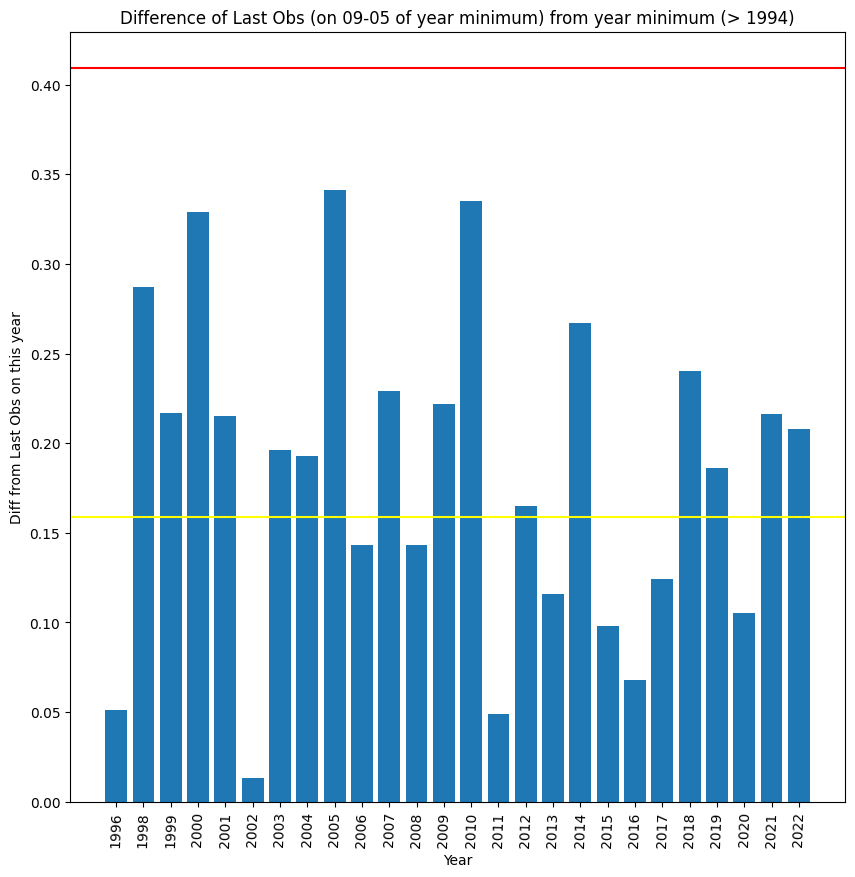

26 years (min year: 1995)
       > 4.25   : 38.46%  (10)
  4.0 to 4.2499 : 61.54%  (16)
       < 4.0    : 0.00%   (0)


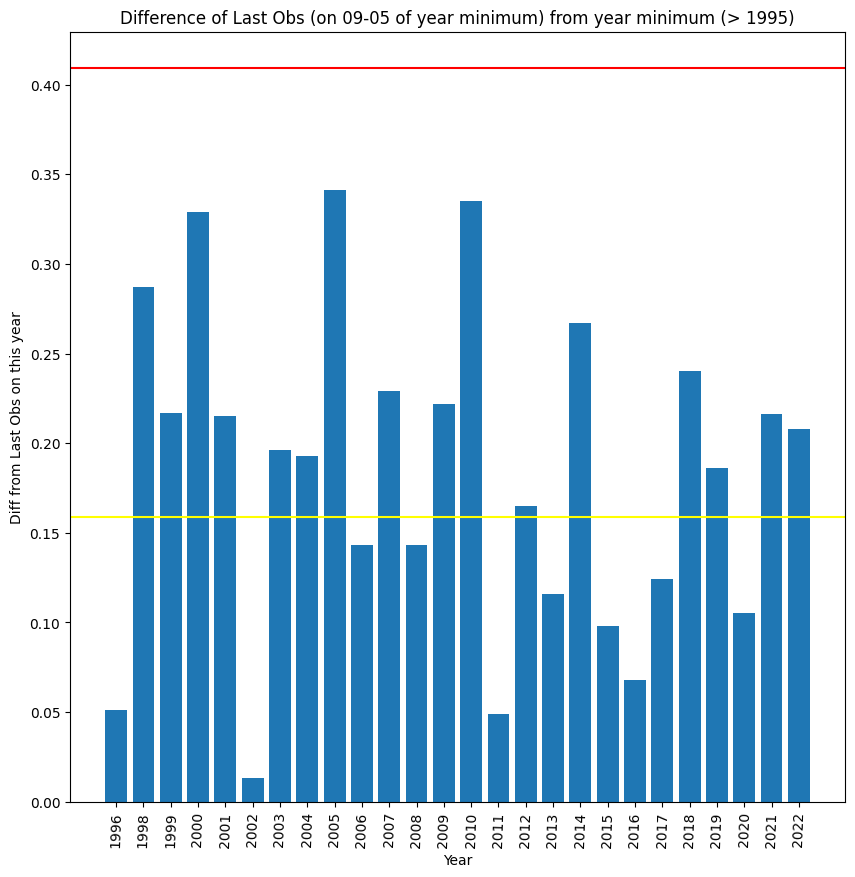

26 years (min year: 1996)
       > 4.25   : 38.46%  (10)
  4.0 to 4.2499 : 61.54%  (16)
       < 4.0    : 0.00%   (0)


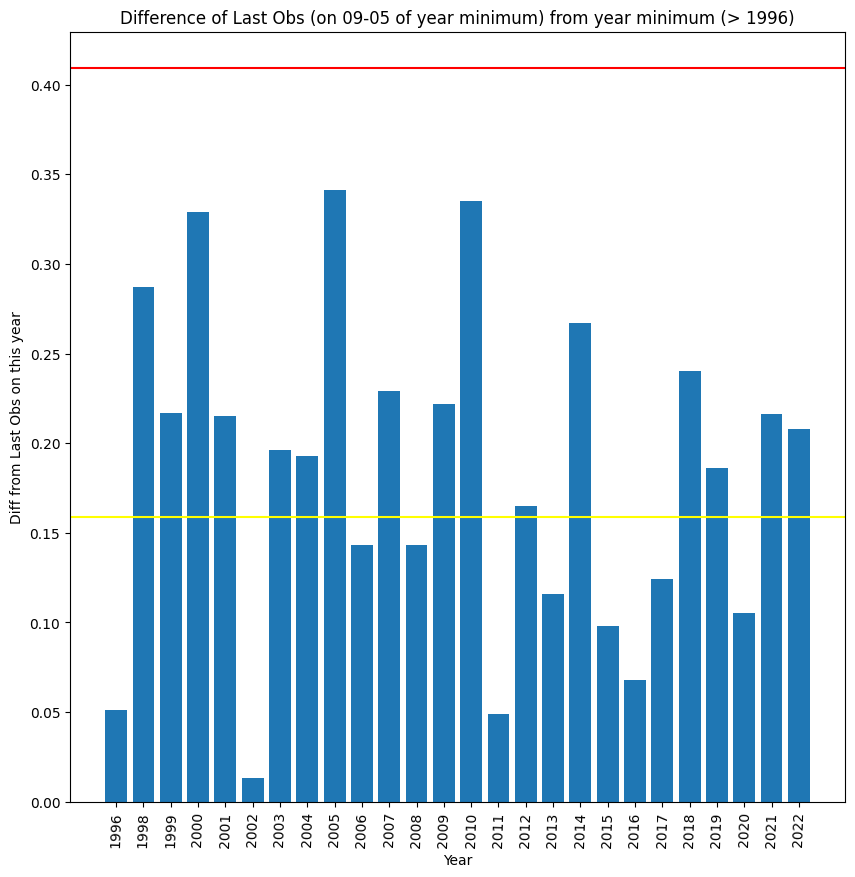

25 years (min year: 1997)
       > 4.25   : 36.00%  (9)
  4.0 to 4.2499 : 64.00%  (16)
       < 4.0    : 0.00%   (0)


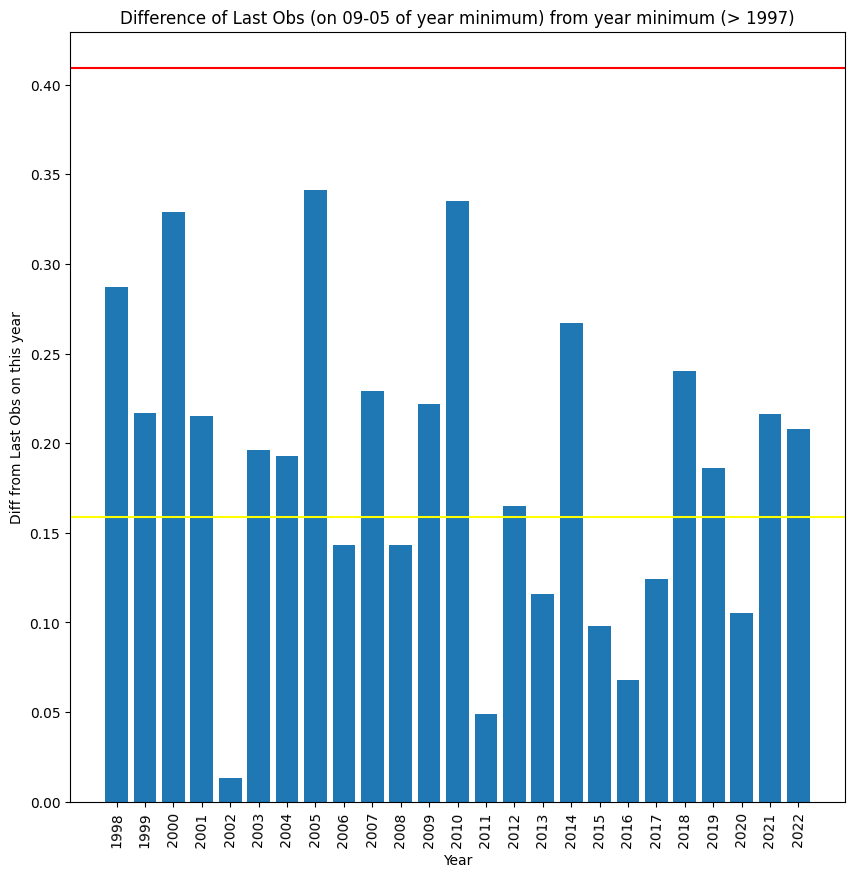

25 years (min year: 1998)
       > 4.25   : 36.00%  (9)
  4.0 to 4.2499 : 64.00%  (16)
       < 4.0    : 0.00%   (0)


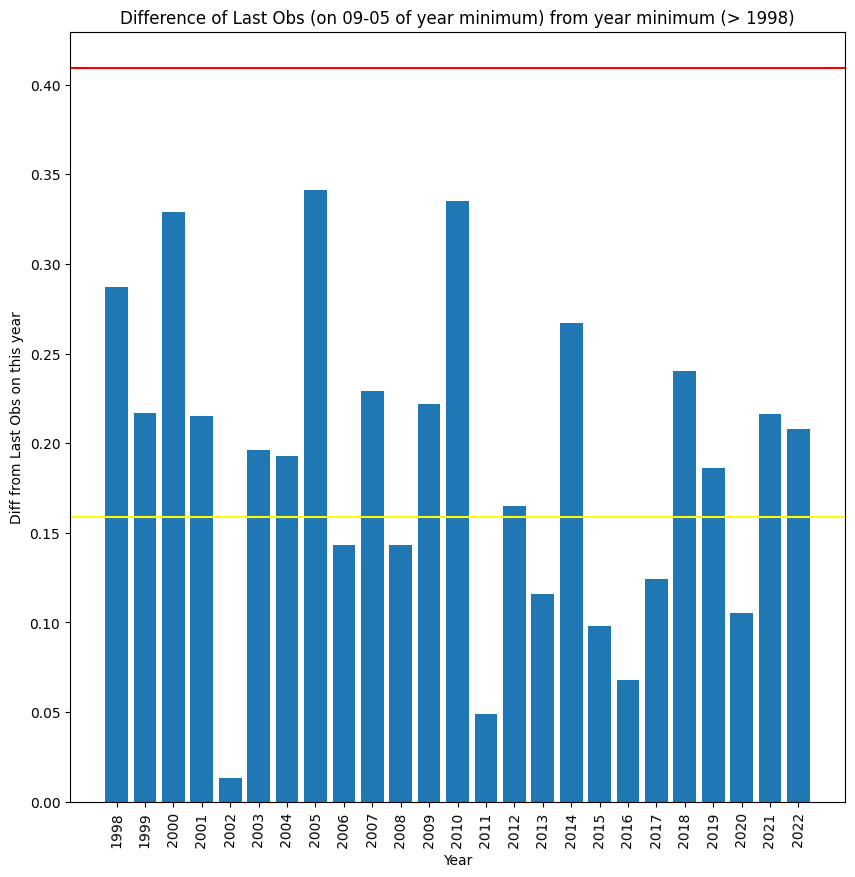

24 years (min year: 1999)
       > 4.25   : 37.50%  (9)
  4.0 to 4.2499 : 62.50%  (15)
       < 4.0    : 0.00%   (0)


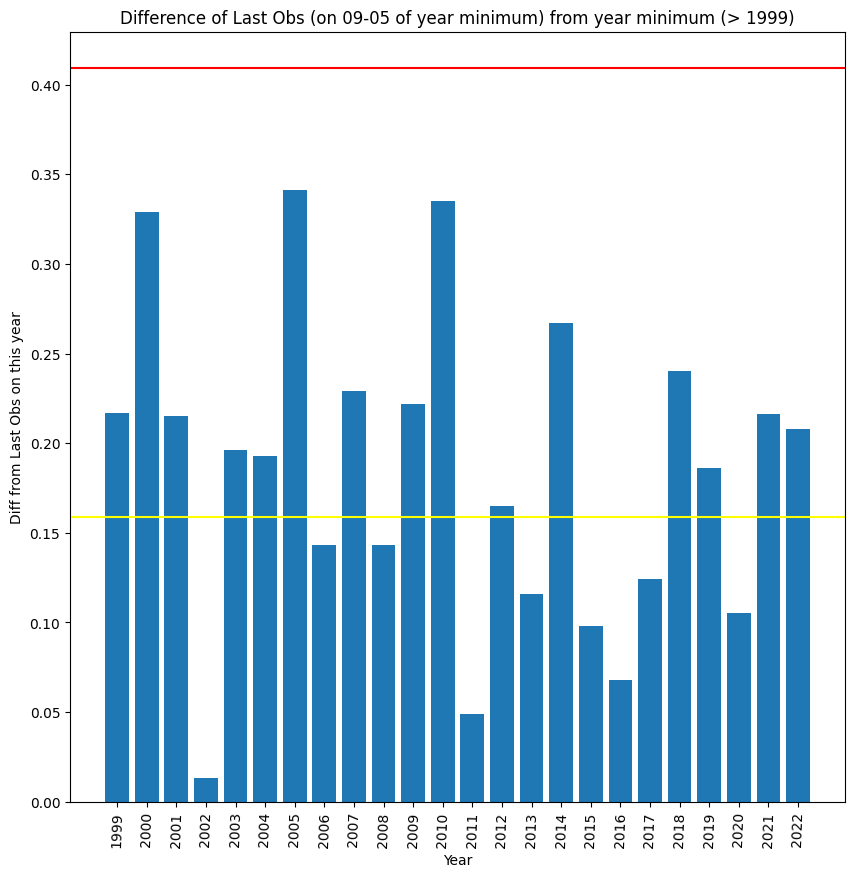

23 years (min year: 2000)
       > 4.25   : 39.13%  (9)
  4.0 to 4.2499 : 60.87%  (14)
       < 4.0    : 0.00%   (0)


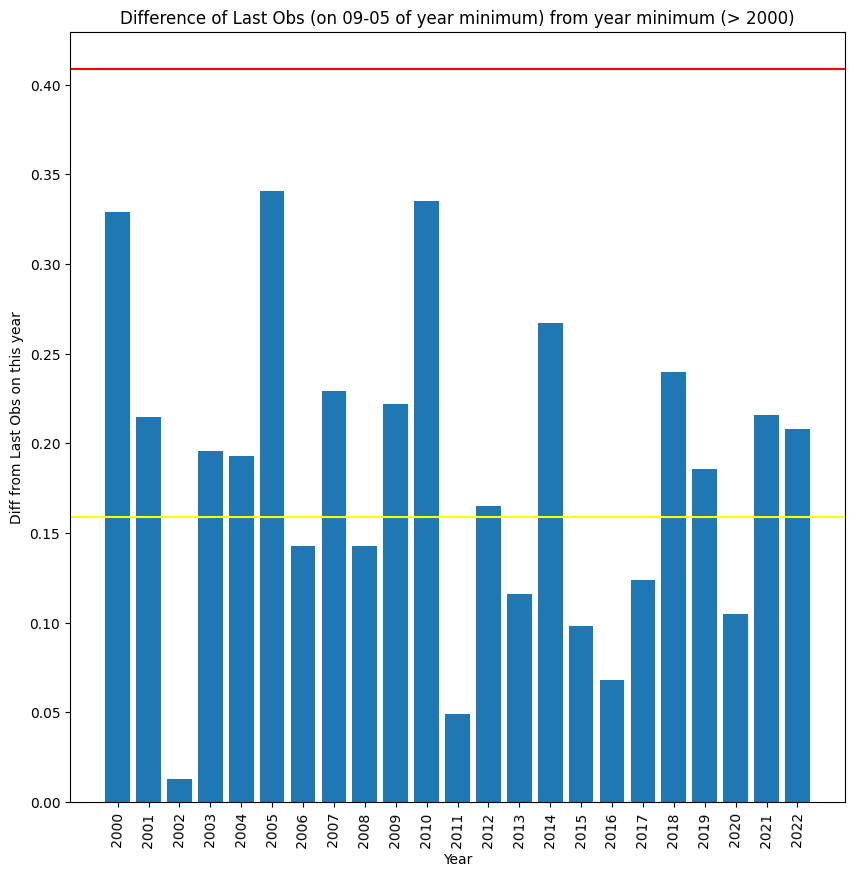

22 years (min year: 2001)
       > 4.25   : 40.91%  (9)
  4.0 to 4.2499 : 59.09%  (13)
       < 4.0    : 0.00%   (0)


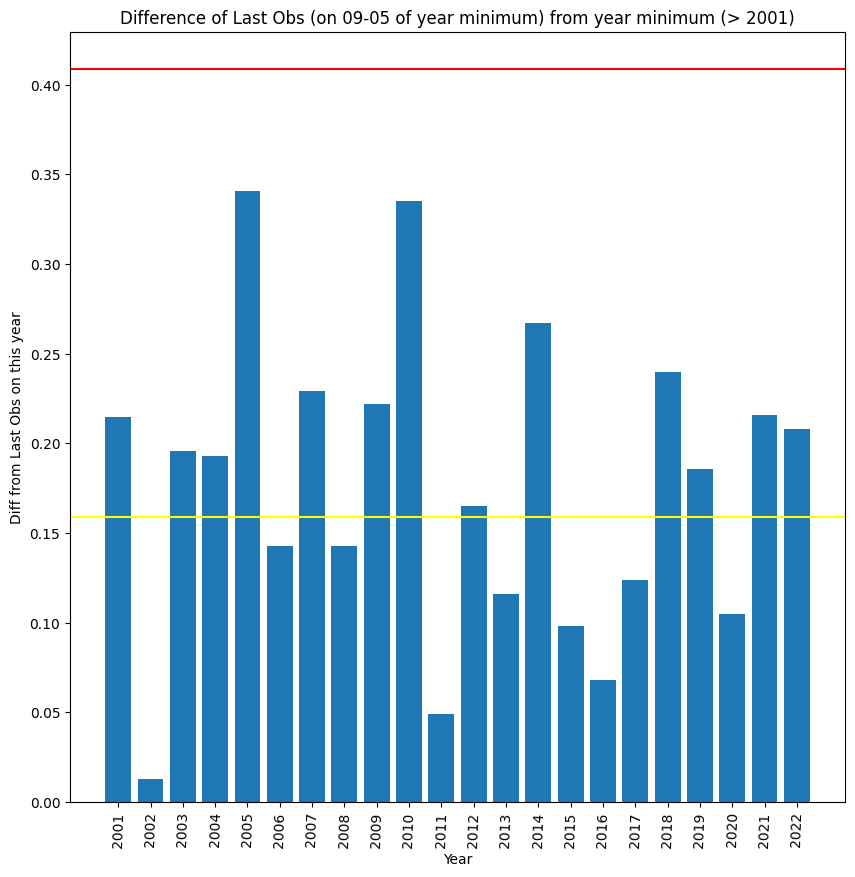

21 years (min year: 2002)
       > 4.25   : 42.86%  (9)
  4.0 to 4.2499 : 57.14%  (12)
       < 4.0    : 0.00%   (0)


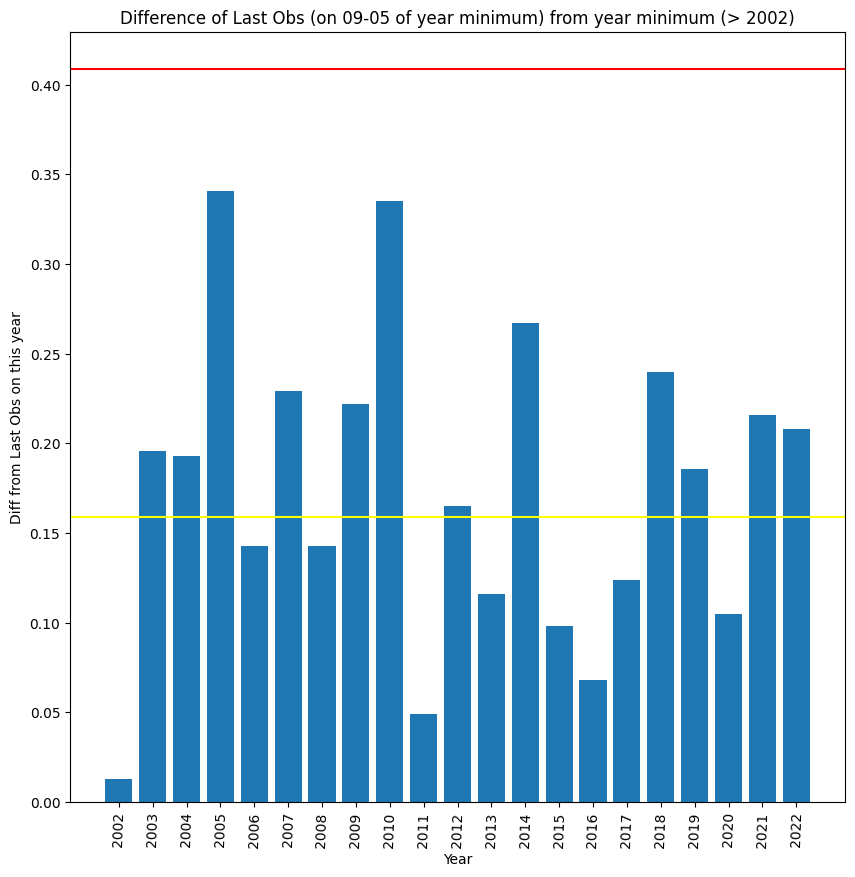

20 years (min year: 2003)
       > 4.25   : 40.00%  (8)
  4.0 to 4.2499 : 60.00%  (12)
       < 4.0    : 0.00%   (0)


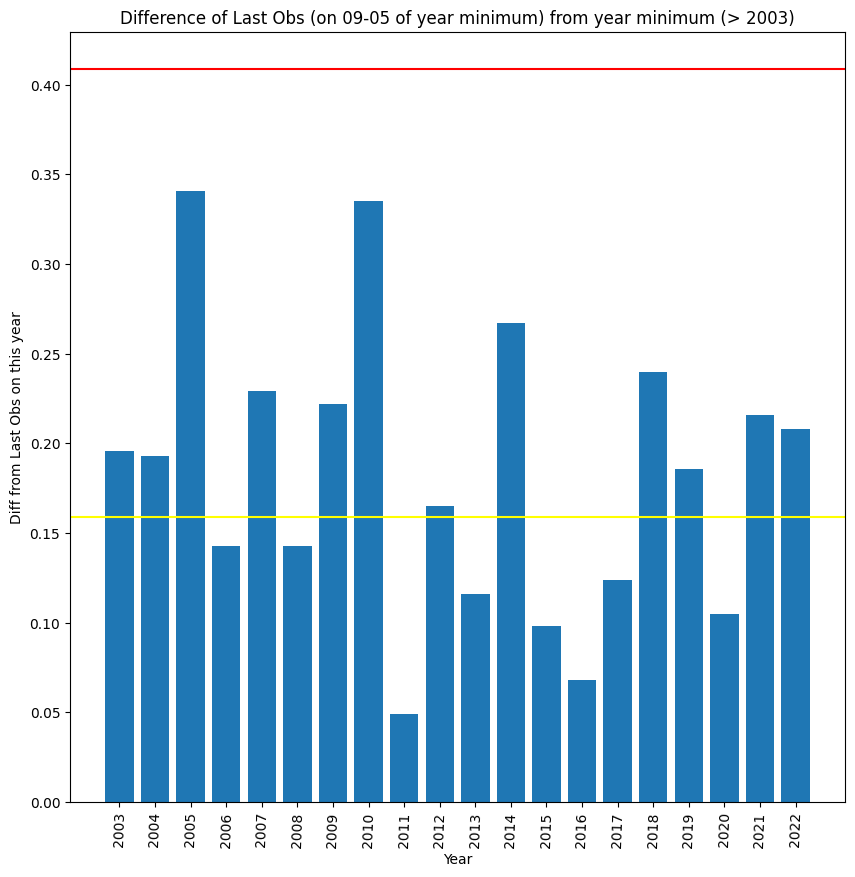

19 years (min year: 2004)
       > 4.25   : 42.11%  (8)
  4.0 to 4.2499 : 57.89%  (11)
       < 4.0    : 0.00%   (0)


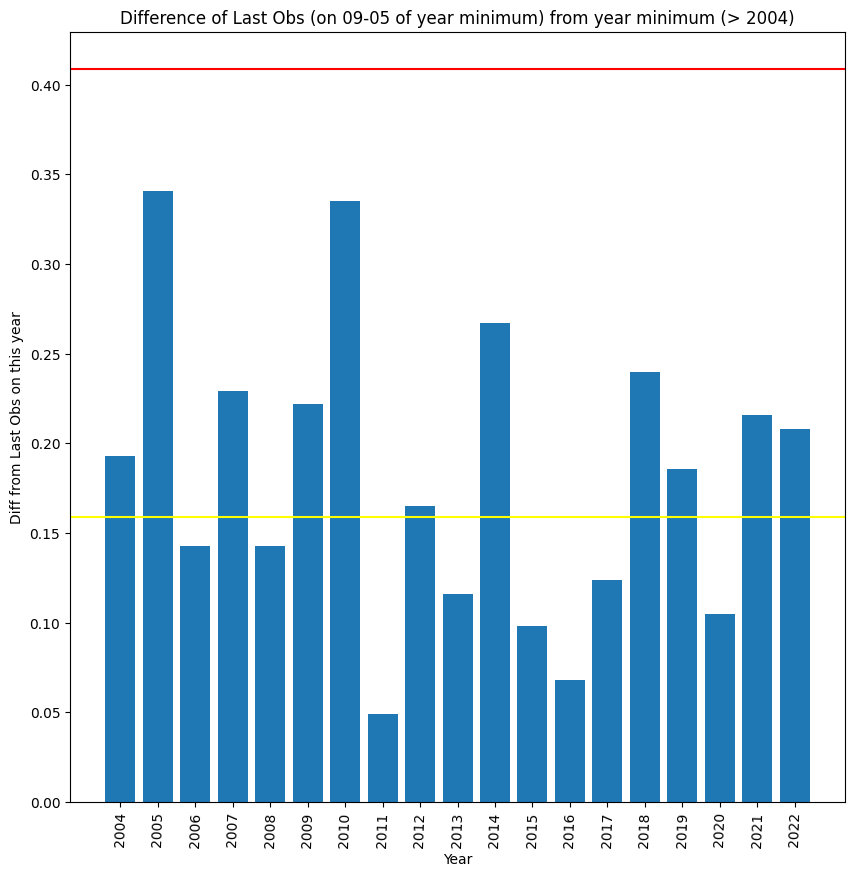

18 years (min year: 2005)
       > 4.25   : 44.44%  (8)
  4.0 to 4.2499 : 55.56%  (10)
       < 4.0    : 0.00%   (0)


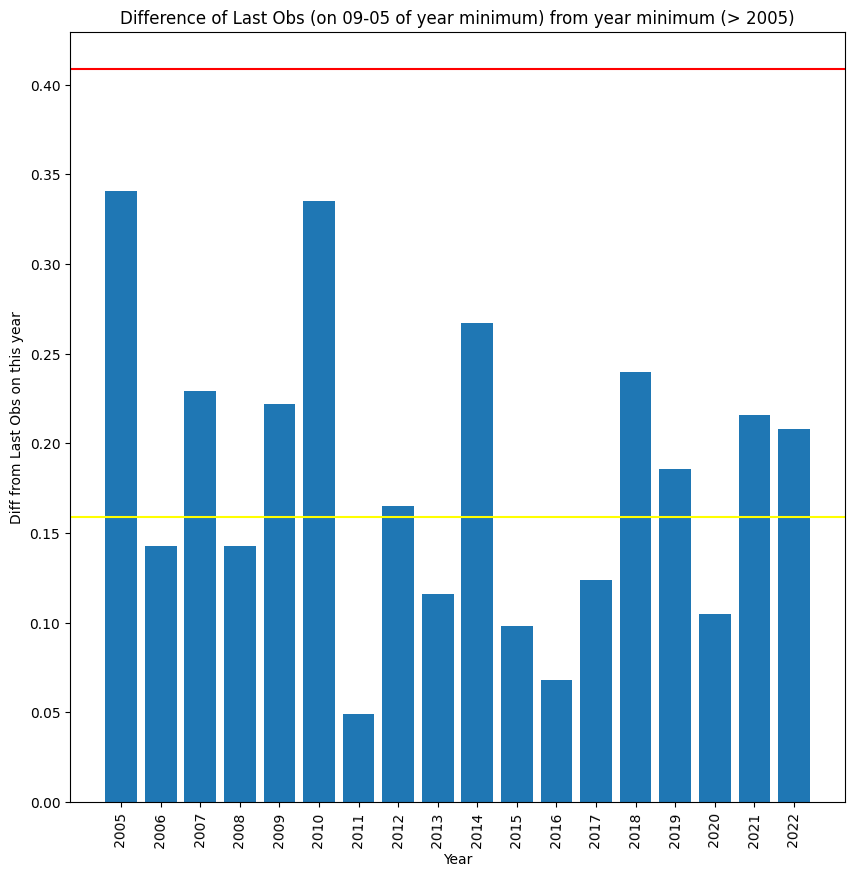

17 years (min year: 2006)
       > 4.25   : 47.06%  (8)
  4.0 to 4.2499 : 52.94%  (9)
       < 4.0    : 0.00%   (0)


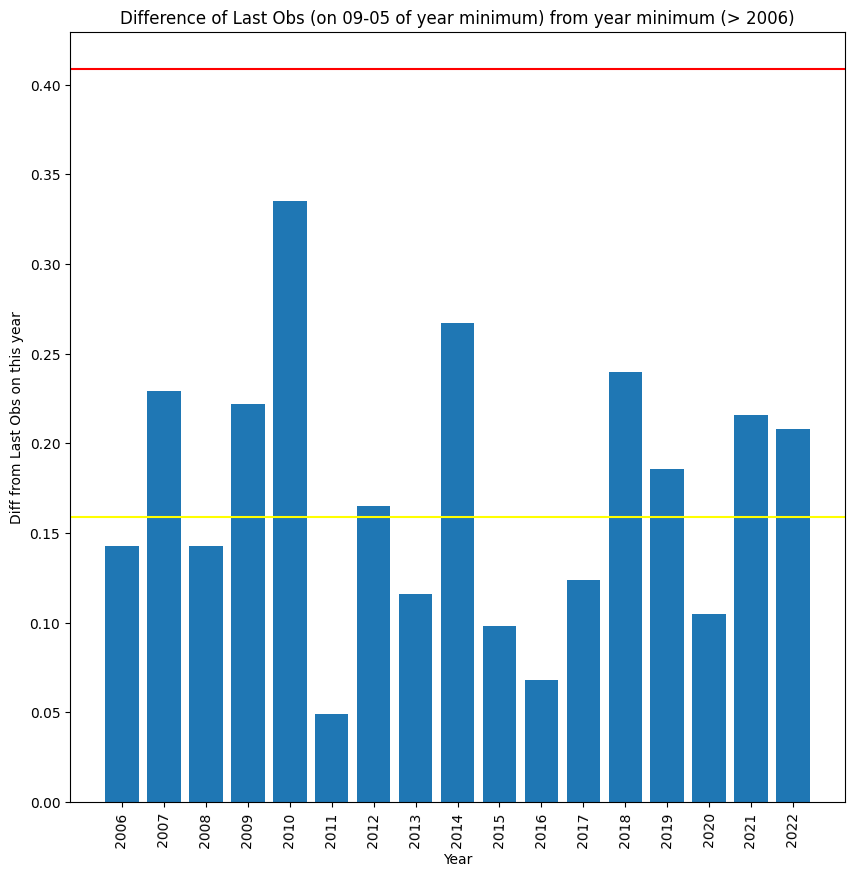

16 years (min year: 2007)
       > 4.25   : 43.75%  (7)
  4.0 to 4.2499 : 56.25%  (9)
       < 4.0    : 0.00%   (0)


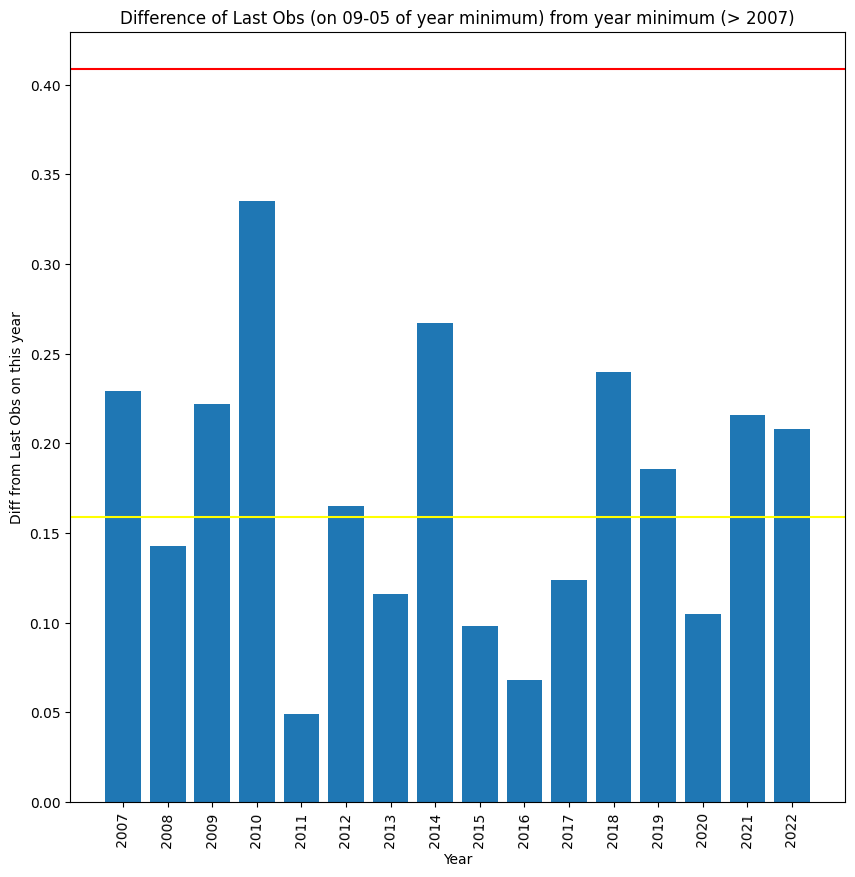

15 years (min year: 2008)
       > 4.25   : 46.67%  (7)
  4.0 to 4.2499 : 53.33%  (8)
       < 4.0    : 0.00%   (0)


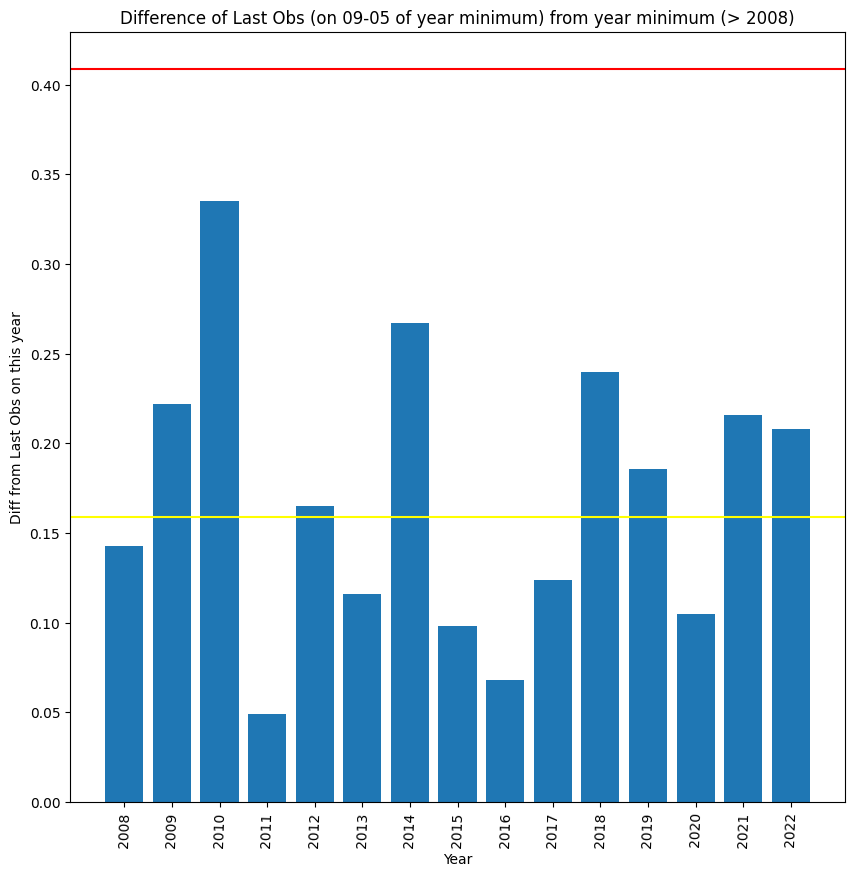

14 years (min year: 2009)
       > 4.25   : 42.86%  (6)
  4.0 to 4.2499 : 57.14%  (8)
       < 4.0    : 0.00%   (0)


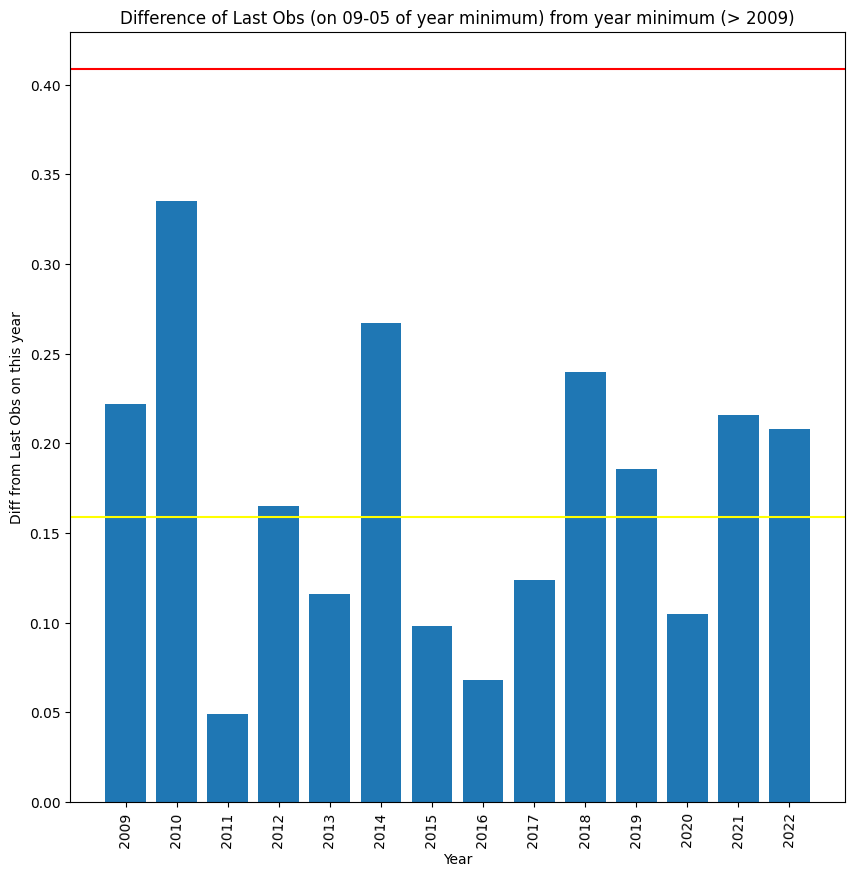

13 years (min year: 2010)
       > 4.25   : 46.15%  (6)
  4.0 to 4.2499 : 53.85%  (7)
       < 4.0    : 0.00%   (0)


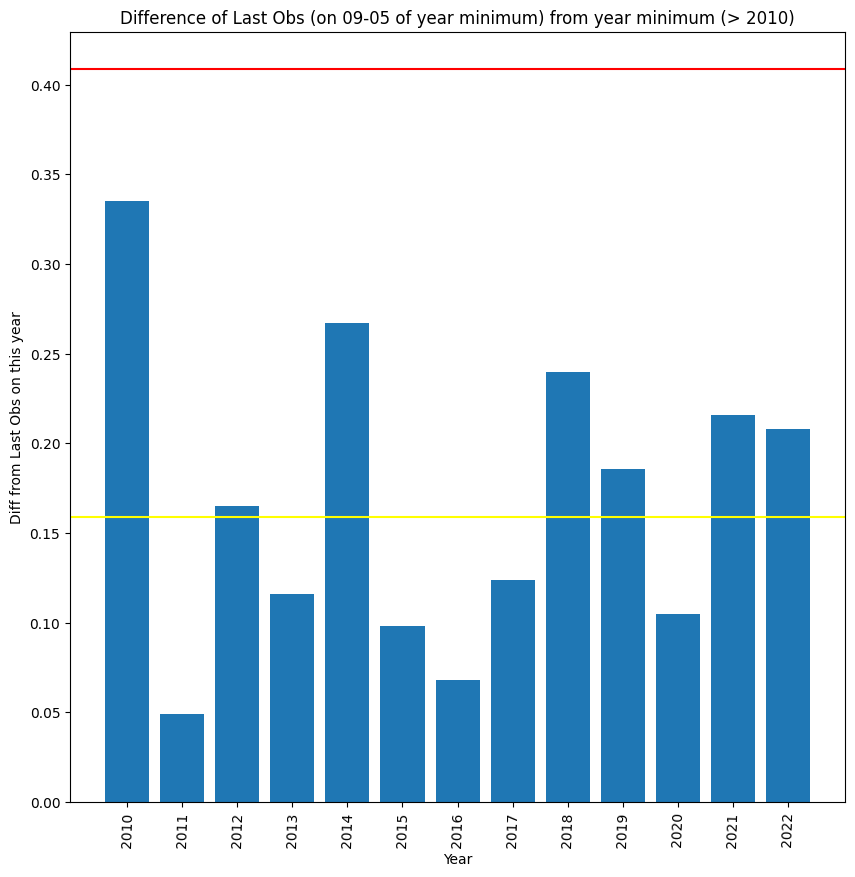

12 years (min year: 2011)
       > 4.25   : 50.00%  (6)
  4.0 to 4.2499 : 50.00%  (6)
       < 4.0    : 0.00%   (0)


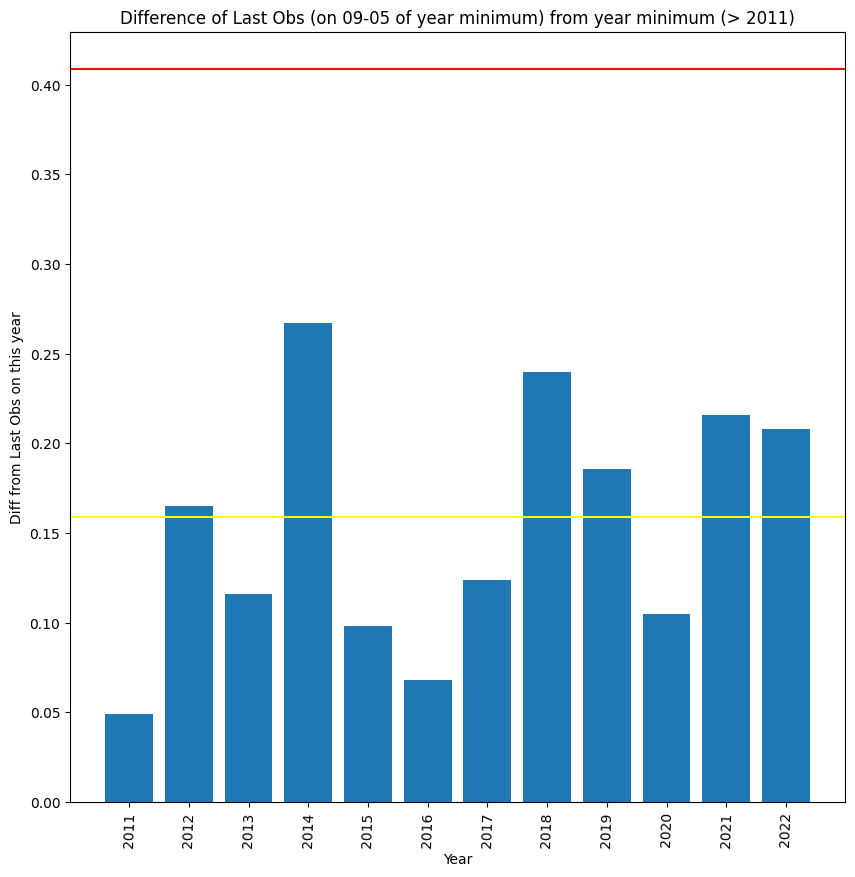

11 years (min year: 2012)
       > 4.25   : 45.45%  (5)
  4.0 to 4.2499 : 54.55%  (6)
       < 4.0    : 0.00%   (0)


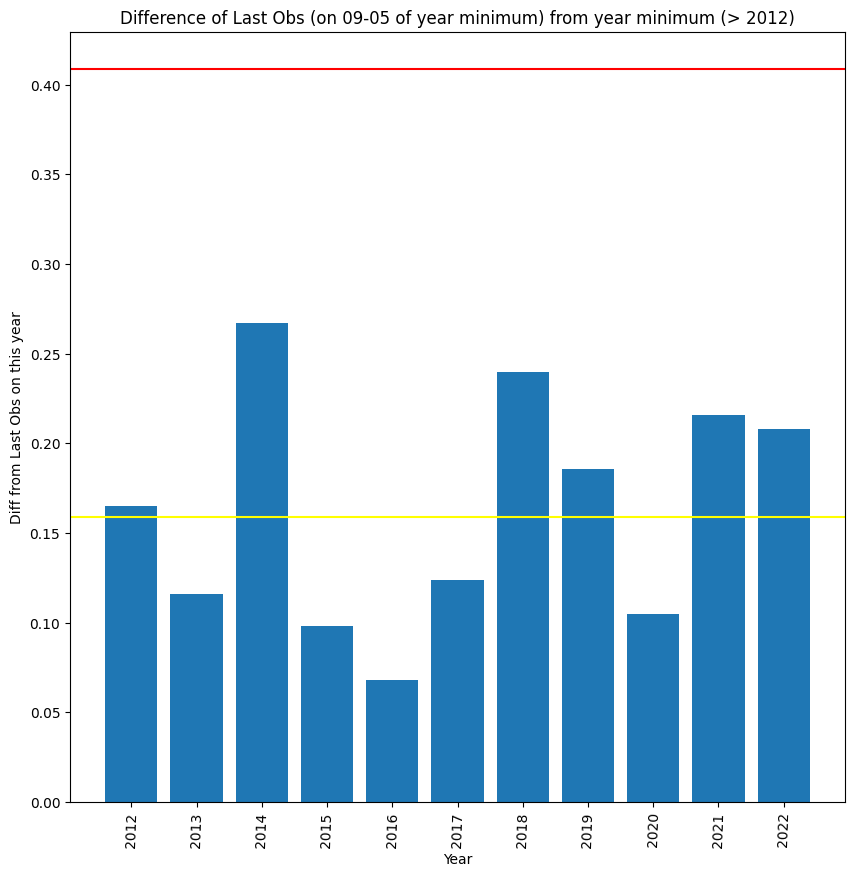

10 years (min year: 2013)
       > 4.25   : 50.00%  (5)
  4.0 to 4.2499 : 50.00%  (5)
       < 4.0    : 0.00%   (0)


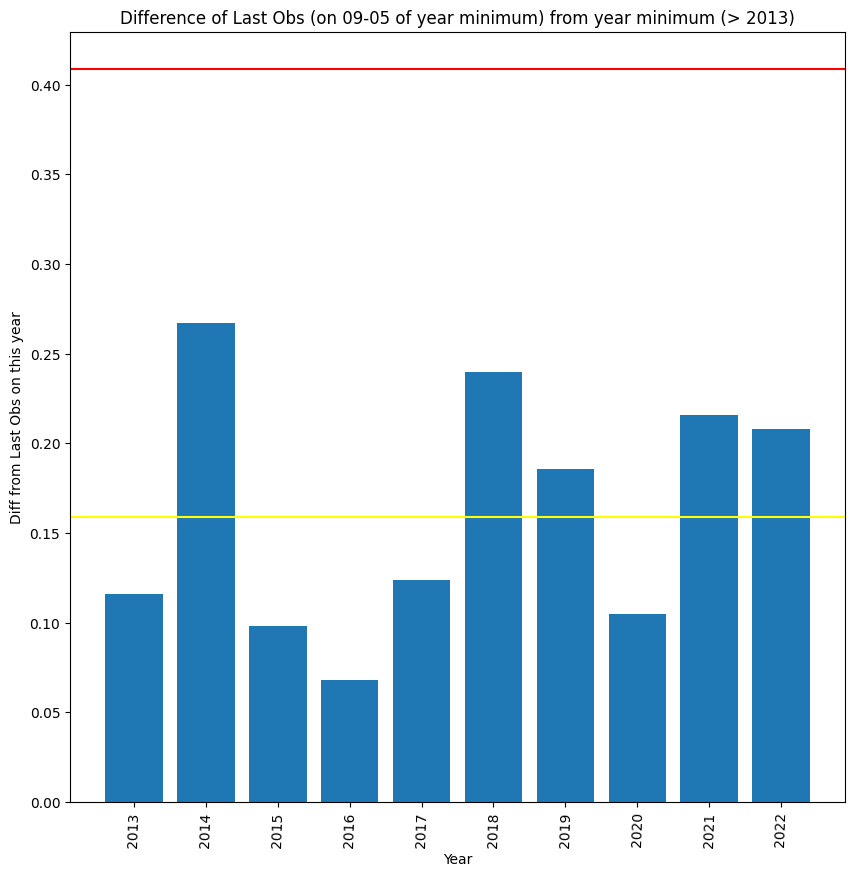

9 years (min year: 2014)
       > 4.25   : 44.44%  (4)
  4.0 to 4.2499 : 55.56%  (5)
       < 4.0    : 0.00%   (0)


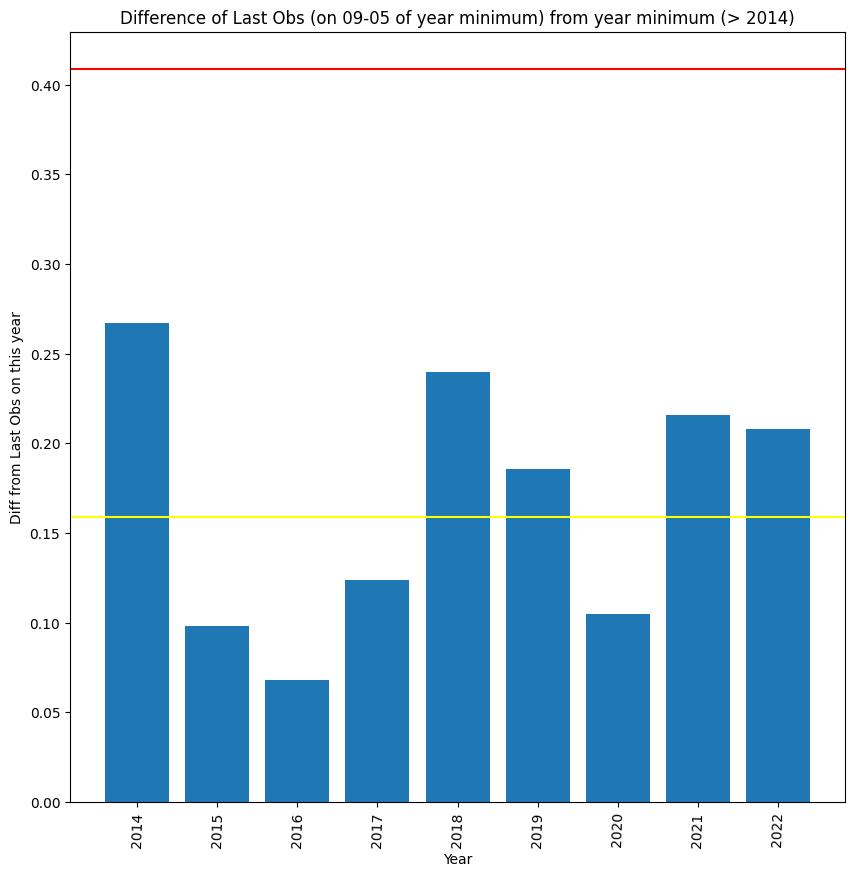

8 years (min year: 2015)
       > 4.25   : 50.00%  (4)
  4.0 to 4.2499 : 50.00%  (4)
       < 4.0    : 0.00%   (0)


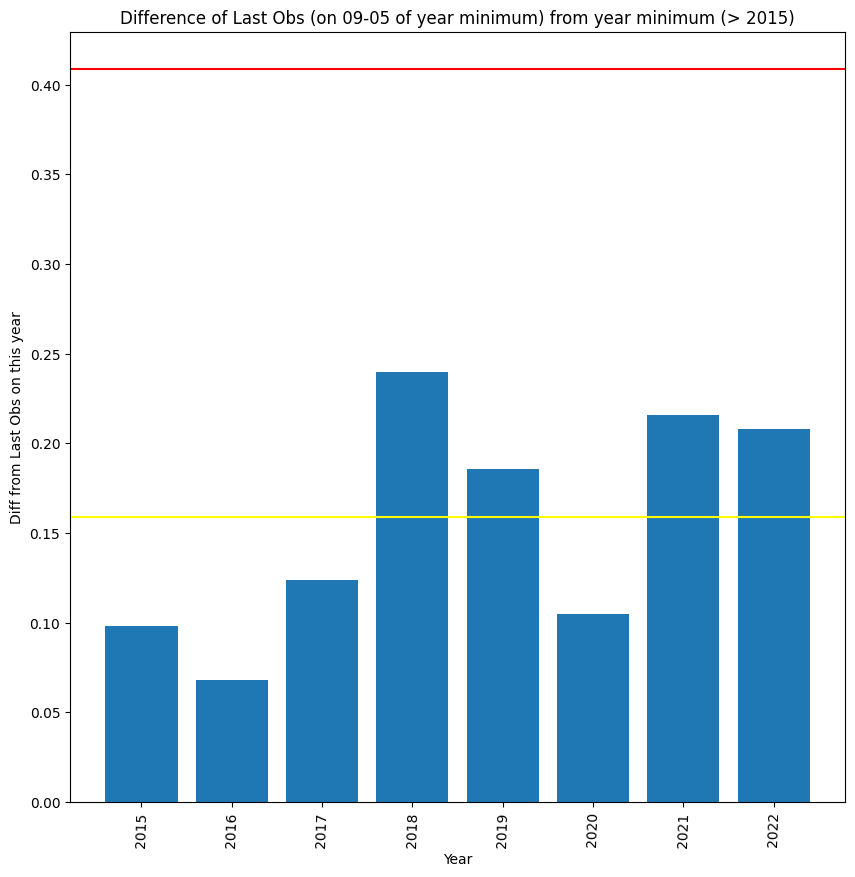

7 years (min year: 2016)
       > 4.25   : 42.86%  (3)
  4.0 to 4.2499 : 57.14%  (4)
       < 4.0    : 0.00%   (0)


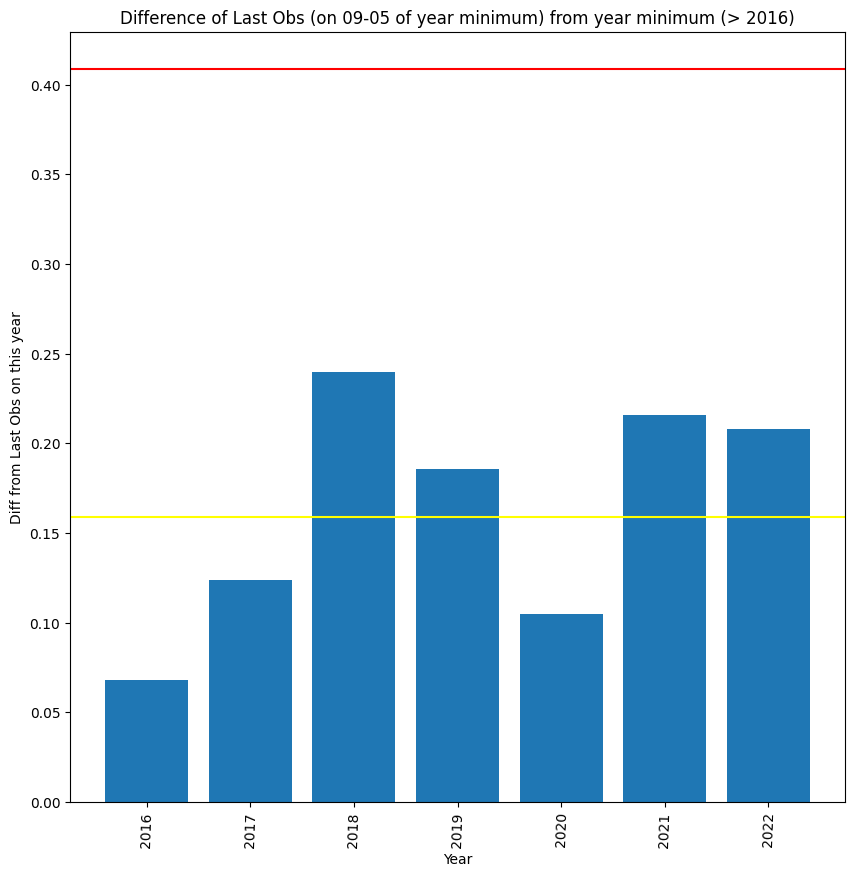

6 years (min year: 2017)
       > 4.25   : 33.33%  (2)
  4.0 to 4.2499 : 66.67%  (4)
       < 4.0    : 0.00%   (0)


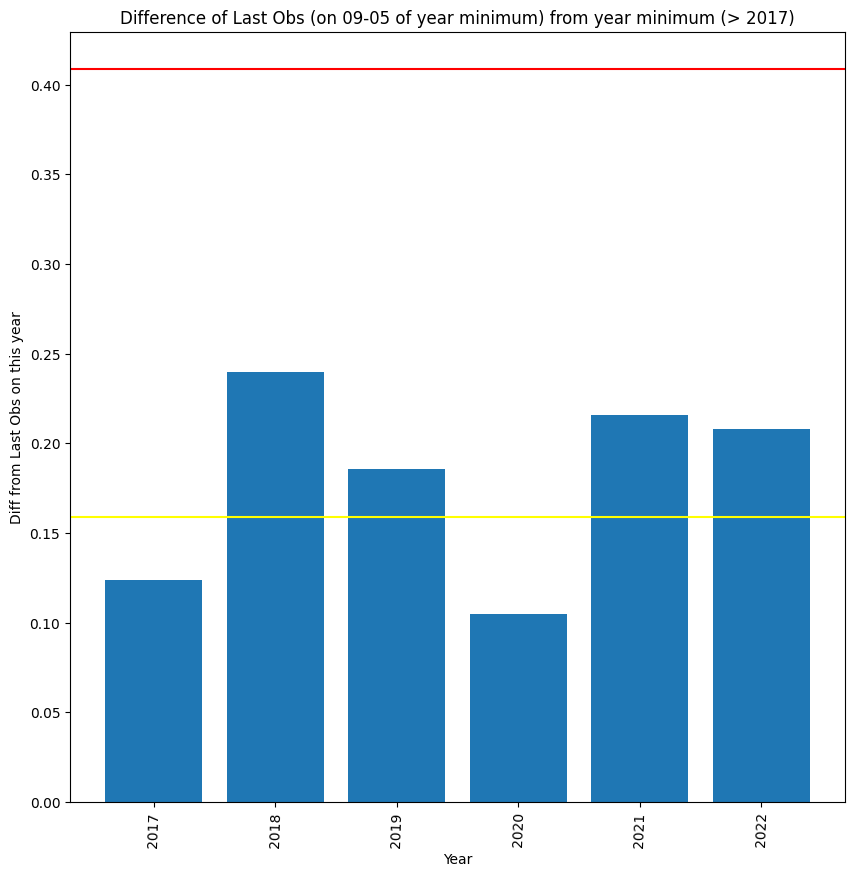

5 years (min year: 2018)
       > 4.25   : 20.00%  (1)
  4.0 to 4.2499 : 80.00%  (4)
       < 4.0    : 0.00%   (0)


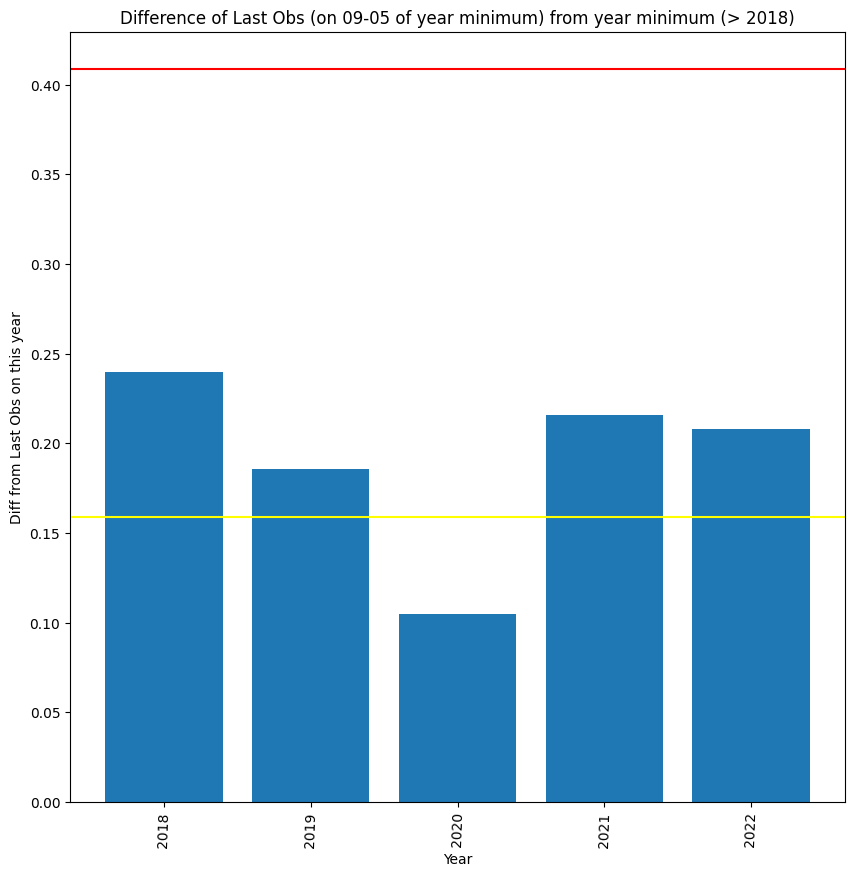

4 years (min year: 2019)
       > 4.25   : 25.00%  (1)
  4.0 to 4.2499 : 75.00%  (3)
       < 4.0    : 0.00%   (0)


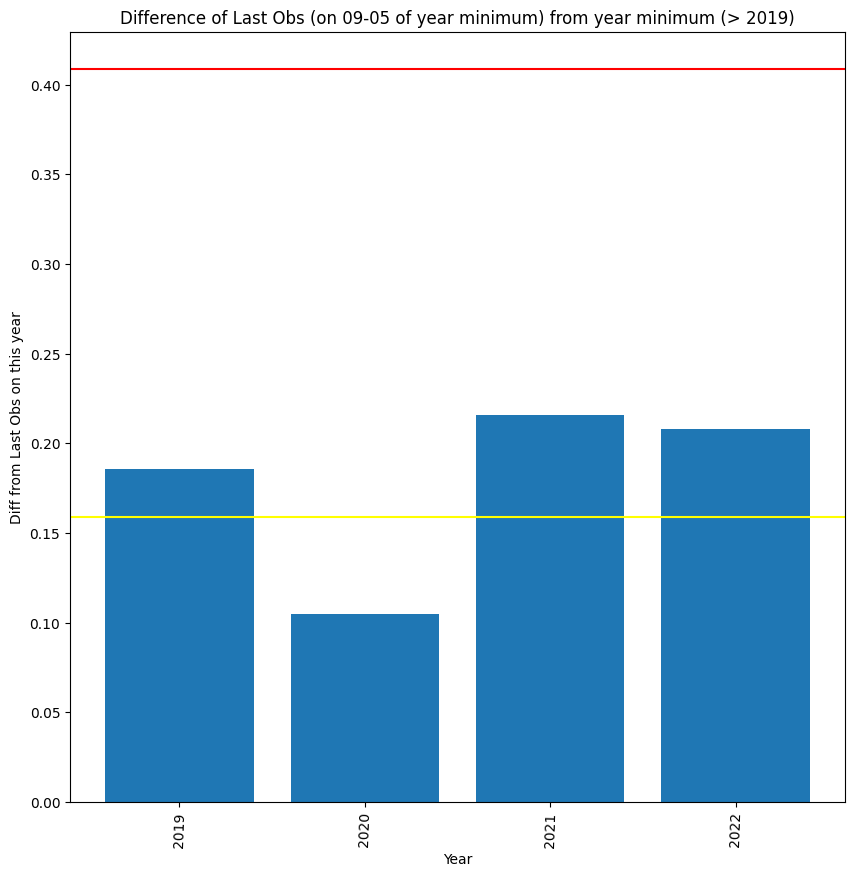

3 years (min year: 2020)
       > 4.25   : 33.33%  (1)
  4.0 to 4.2499 : 66.67%  (2)
       < 4.0    : 0.00%   (0)


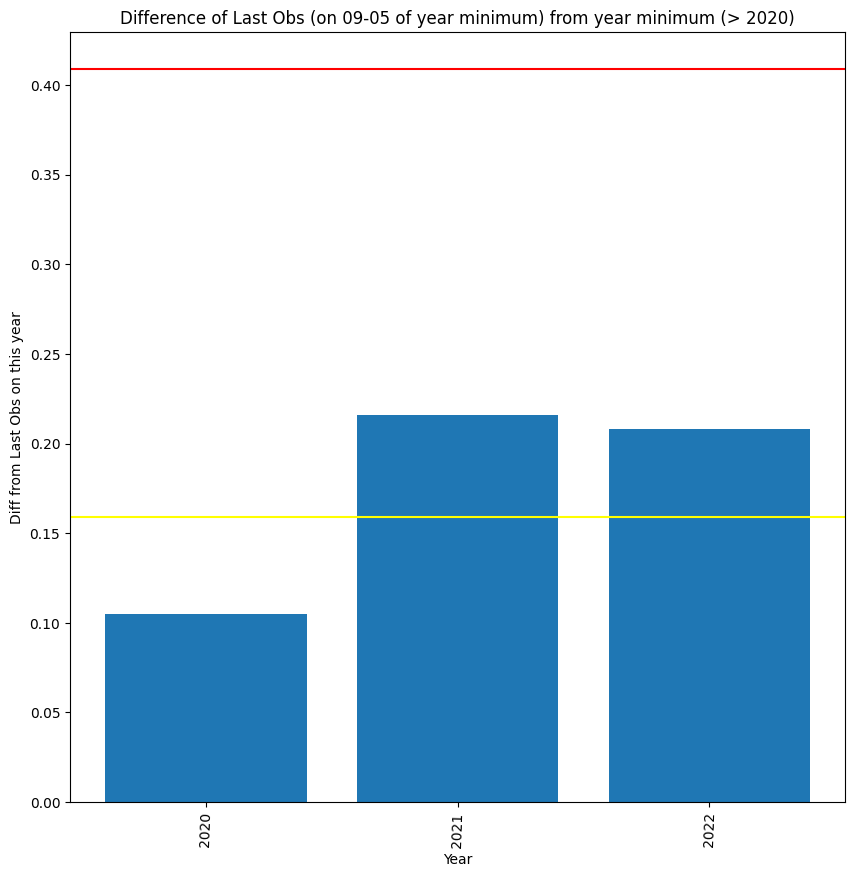

2 years (min year: 2021)
       > 4.25   : 0.00%  (0)
  4.0 to 4.2499 : 100.00%  (2)
       < 4.0    : 0.00%   (0)


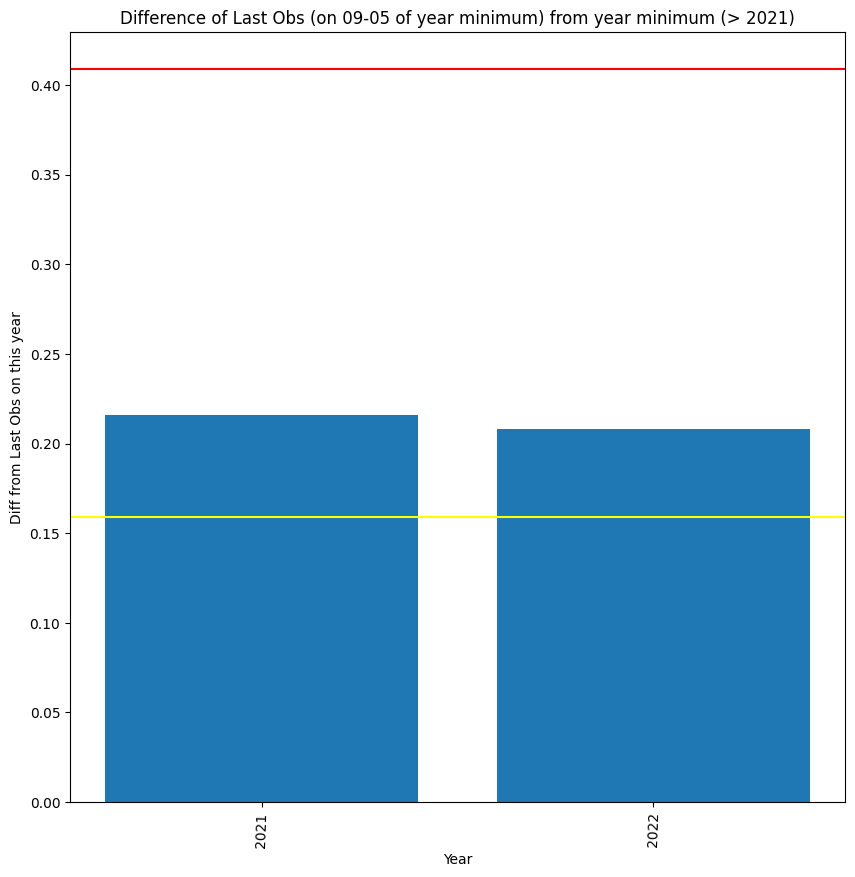

In [181]:
p2s = []
p1s = []
p0s = []
min_years = []
for min_year in range(1979, 2022):
    #last_obs_date = datetime.strptime(last_obs_date_str, '%Y-%m-%d')

    # date_objects contains the minimum dates
    # Step 2: Extract the last month and day components from datetime objects
    last_obs_date_mm_dd_str = last_obs_date.strftime('%m-%d')
    last_obs_diff_from_year_min = {}

    for min_date in date_objects:
        min_date_str = min_date.strftime('%Y-%m-%d')
        # Step 2: Extract the year components from datetime objects
        min_date_year_str = min_date.strftime('%Y')
        last_obs_date_str_for_min_year = f"{min_date_year_str}-{last_obs_date_mm_dd_str}"
        last_obs_date_for_min_year = datetime.strptime(last_obs_date_str_for_min_year, '%Y-%m-%d')

        min_date_ts = pd.Timestamp(min_date)
        #print(min_date_ts)
        result = df_interp[df_interp['ds'] == min_date_ts]
        if result.empty:
            continue
        min_for_year = result.iloc[0]['y']

        last_obs_ts_for_min_year = pd.Timestamp(last_obs_date_for_min_year)
        #print(last_obs_ts_for_min_year)
        result = df_interp[df_interp['ds'] == last_obs_ts_for_min_year]
        if result.empty:
            continue
        last_obs_y_for_min_year = result.iloc[0]['y']

        diff_from_obs = last_obs_y_for_min_year - min_for_year

        # include years only when minimum is in future
        if last_obs_ts_for_min_year < min_date_ts:
            if int(min_date_year_str) >= min_year:
                last_obs_diff_from_year_min[min_date_year_str] = diff_from_obs

    threshold_425 = last_obs - 4.25
    threshold_400 = last_obs - 4.0
    num_total = 0
    above_425 = 0
    between_400_425 = 0
    below_400 = 0

    date_labels = []
    diff_values = []
    for [year, diff] in last_obs_diff_from_year_min.items():
        date_labels.append(year)
        diff_values.append(diff)
        num_total += 1
        if diff <= threshold_425:
            above_425 += 1
        elif diff <= threshold_400 and diff > threshold_425 :
            between_400_425 += 1
        elif diff > threshold_400:
            below_400 += 1
    
    p2 = 100 * above_425 / num_total
    p1 = 100 * between_400_425 / num_total
    p0 = 100 * below_400 / num_total
    p2s.append(p2)
    p1s.append(p1)
    p0s.append(p0)
    min_years.append(min_year)
    print(f"{num_total} years (min year: {min_year})")
    print(f"       > 4.25   : {p2:03.2f}%  ({above_425})")
    print(f"  4.0 to 4.2499 : {p1:02.2f}%  ({between_400_425})")
    print(f"       < 4.0    : {p0:03.2f}%   ({below_400})")


    # Step 3: Create a bar chart
    plt.figure(figsize=(10, 10))
    plt.bar(date_labels, diff_values)
    plt.xlabel('Year')
    plt.ylabel('Diff from Last Obs on this year')
    plt.title(f'Difference of Last Obs (on {last_obs_date_mm_dd_str} of year minimum) from year minimum (> {min_year})')
    plt.xticks(rotation=88)  # Rotate x-axis labels for better readability
    plt.axhline(last_obs - 4.25, color = 'yellow')
    plt.axhline(last_obs - 4.0, color = 'red')
    #plt.yticks(range(max(counts_for_all_days) + 1))  # Set y-axis ticks to integers
    plt.show()


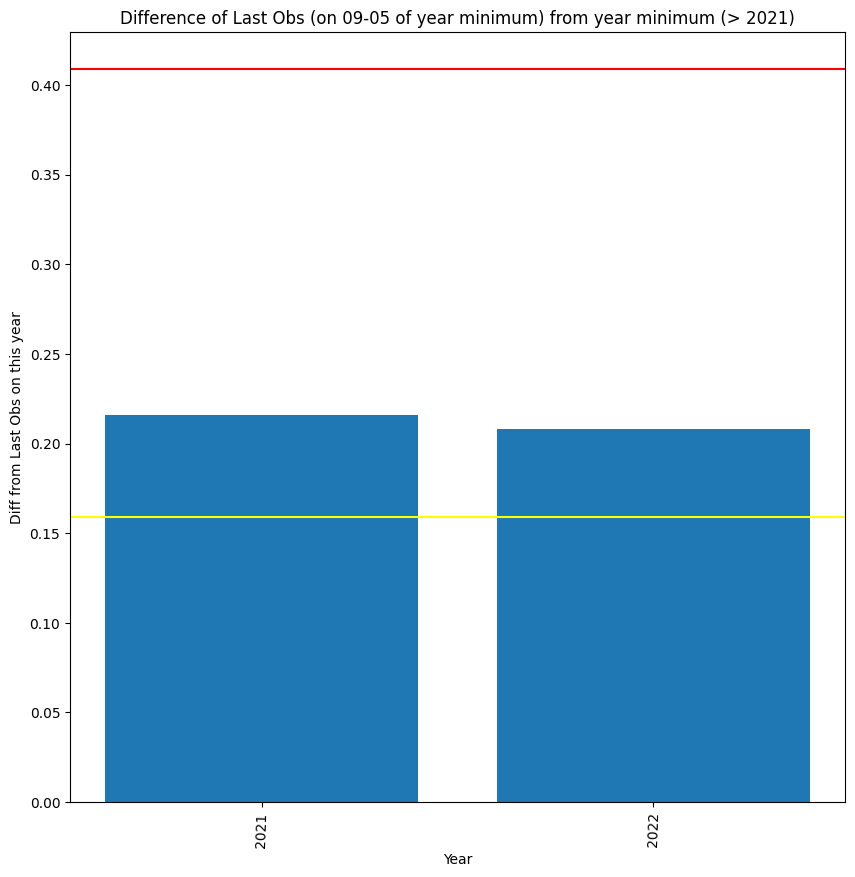

In [182]:
# Step 3: Create a bar chart
plt.figure(figsize=(10, 10))
plt.bar(date_labels, diff_values)
plt.xlabel('Year')
plt.ylabel('Diff from Last Obs on this year')
plt.title(f'Difference of Last Obs (on {last_obs_date_mm_dd_str} of year minimum) from year minimum (> {min_year})')
plt.xticks(rotation=88)  # Rotate x-axis labels for better readability
plt.axhline(last_obs - 4.25, color = 'yellow')
plt.axhline(last_obs - 4.0, color = 'red')
#plt.yticks(range(max(counts_for_all_days) + 1))  # Set y-axis ticks to integers
plt.show()

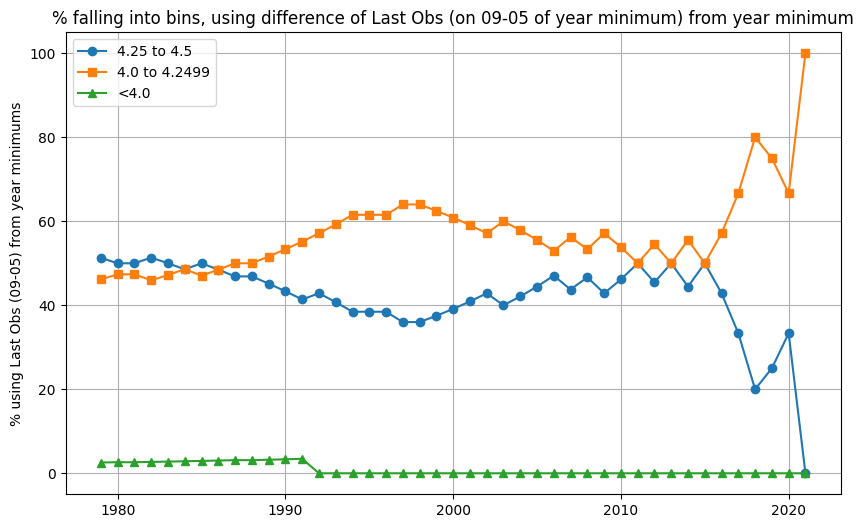

In [185]:

# Create the line chart
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(min_years, p2s, label='4.25 to 4.5', marker='o')
plt.plot(min_years, p1s, label='4.0 to 4.2499', marker='s')
plt.plot(min_years, p0s, label='<4.0', marker='^')

# Add labels and a legend
plt.ylabel(f'% using Last Obs ({last_obs_date_mm_dd_str}) from year minimums')
plt.title(f'% falling into bins, using difference of Last Obs (on {last_obs_date_mm_dd_str} of year minimum) from year minimum')
plt.legend()

# Show the plot
plt.grid(True)  # Optional: Add grid lines
plt.show()


In [172]:
# Current year forecast graph 
import pandas as pd
import plotly.graph_objects as go
from prophet.plot import plot_plotly, plot_components_plotly

#pip install ipywidgets

# Assuming you have the forecast data in a DataFrame called forecast_df
forecast_df = forecast.loc[-365:]
# The DataFrame should contain a 'ds' column with the dates and a 'yhat' column with the forecasted values.

# Convert the 'ds' column to pandas datetime objects (if not already)
forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
forecast_df['yhat'] = forecast_df['yhat'] - offset_avg
forecast_df['yhat_lower'] = forecast_df['yhat_lower'] - offset_avg
forecast_df['yhat_upper'] = forecast_df['yhat_upper'] - offset_avg

# Plot the forecast using plot_plotly
fig = plot_plotly(model, forecast_df)
# Set the default range for the x-axis (datetimestamp)
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-10-31')
fig.update_xaxes(range=[start_date, end_date])
fig.update_yaxes(range=[3.5, 5])  
fig.update_layout(title_text="Arctic Sea Ice-Extent Forecast only using historical data)")
fig.update_yaxes(title_text="Extent (10^6 km^2)")
fig.show()

# Plot the forecast components using plot_components_plotly
fig_comp = plot_components_plotly(model, forecast_df)
fig_comp.show()

In [173]:
### VALIDATION AND CROSS VALIDATION BELOW

In [ ]:
#### VALIDATION
import pandas as pd

# Number of iterations you want to perform (validate_years)
validate_years = 20
# Period of days into the future to forecast
# don't forecast too far into the future to make sure we only get the minimum for the year of interest
period = 180

df_truncated = df_new
# Loop to truncate data by one year for each iteration
total_abs_error = 0
forecast_in_range_count = 0

last_date = df_truncated['ds'].iloc[-1]
print(f"Validating forecast minimum value for {validate_years} years prior to last observation of: {last_date}")

for i in range(validate_years):

    # First get the previous year's minimum
    most_recent_year = df_truncated['ds'].dt.year.iloc[-1] - 1
    
    # Step 3: Use boolean indexing to slice the DataFrame for the identified year range
    start_date = pd.to_datetime(f'{most_recent_year}-01-01')
    end_date = pd.to_datetime(f'{most_recent_year}-12-31')
    df_most_recent_year = df_truncated[(df_truncated['ds'] >= start_date) & (df_truncated['ds'] <= end_date)]
    min_value = df_most_recent_year['y'].min()
    print(f"{most_recent_year}: {min_value}")
    
    # Get the last date in the current DataFrame
    last_date = df_truncated['ds'].iloc[-1]

    # Truncate data to one year prior
    one_year_prior = last_date - pd.DateOffset(years=1)

    # Slice the DataFrame to include data up to one year prior
    df_truncated = df_truncated[df_truncated['ds'] <= one_year_prior]
    
    cutoff_date_timestamp = df_truncated['ds'].iloc[-1]
    min_max_dates = ['1979-09-22', '1980-09-05', '1981-09-11', '1982-09-14', '1983-09-09', '1984-09-16', '1985-09-10', '1986-09-07', '1987-09-03', '1988-09-11', '1989-09-23', '1990-09-22', '1991-09-17', '1992-09-07', '1993-09-14', '1994-09-06', '1995-09-05', '1996-09-10', '1997-09-04', '1998-09-18', '1999-09-13', '2000-09-11', '2001-09-20', '2002-09-19', '2003-09-18', '2004-09-18', '2005-09-21', '2006-09-15', '2007-09-15', '2008-09-18', '2009-09-13', '2010-09-20', '2011-09-09', '2012-09-16', '2013-09-14', '2014-09-17', '2015-09-09', '2016-09-07', '2017-09-14', '2018-09-22', '2019-09-19', '2020-09-13', '2021-09-15', '2022-09-16', '1979-03-02', '1980-03-05', '1981-03-15', '1982-02-27', '1983-03-15', '1984-03-18', '1985-03-18', '1986-03-11', '1987-02-21', '1988-03-10', '1989-03-07', '1990-03-13', '1991-02-25', '1992-03-12', '1993-03-14', '1994-02-21', '1995-04-01', '1996-02-21', '1997-03-21', '1998-02-25', '1999-03-31', '2000-03-03', '2001-03-05', '2002-03-10', '2003-03-21', '2004-03-10', '2005-03-10', '2006-03-12', '2007-03-11', '2008-02-27', '2009-03-03', '2010-04-01', '2011-03-08', '2012-03-18', '2013-03-15', '2014-03-21', '2015-02-22', '2016-03-22', '2017-03-06', '2018-03-15', '2019-03-12', '2020-03-04', '2021-03-12', '2022-02-21', '2023-03-06']

    # Convert the list of date strings to pandas Timestamp objects
    timestamps = pd.to_datetime(min_max_dates)

    # Filter the timestamps to include only dates before the cutoff_date
    cutoff_change_dates = timestamps[timestamps <= cutoff_date_timestamp]

    # Sort the Timestamps in increasing order
    cutoff_change_dates = cutoff_change_dates.sort_values()

    # Convert the filtered timestamps back to date strings
    cutoff_change_dates_strings = cutoff_change_dates.strftime('%Y-%m-%d').tolist()

    # see cross validation xlsx
    # for 7-21 to 8-21: keep trend tight, and no regularization penalty for seasonality
    # validation with tuning from cross-validation
    changepoint_prior_scale = 0.001
    seasonality_prior_scale = 10
    [validate_forecast, model] = doForecastWithParams(df_truncated, period, changepoint_prior_scale, seasonality_prior_scale, cutoff_change_dates_strings)
    # validation without any tuning:
    # [validate_forecast, model] = doForecastWithParams(df_truncated, period)
    
    forecasted_values = validate_forecast['yhat']
    forecasted_lower_bounds = validate_forecast['yhat_lower']
    forecasted_upper_bounds = validate_forecast['yhat_upper']

    # Print the minimum value for the forecast
    min_value_forecast = forecasted_values.min()
    min_value_error = min_value - min_value_forecast
    total_abs_error += abs(min_value_error)
    print(f"{most_recent_year}")
    print("  Minimum Forecast Value: " + str(round(min_value_forecast, 3)))
    print("  Actual Minimum Value: " + str(round(min_value, 3)))
    print("  Error: " + str(round(min_value_error, 3)))
    print("")
    # Print the ± range values for the forecast
    forecast_lower = forecasted_lower_bounds.min()
    forecast_upper = forecasted_upper_bounds.min()
    forecast_in_range = (forecast_lower <= min_value) and (min_value <= forecast_upper)
    if forecast_in_range:
        forecast_in_range_count += 1
        is_in_range = "YES"
    else:
        is_in_range = "NO"
    print("  Forecast 99.5% Interval:")
    print("    Lower Bound: " + str(round(forecast_lower,3)))
    print("    Upper Bound: " + str(round(forecast_upper,3)))
    print("")
    print(f"  Forecast in 99.5% Interval?: {is_in_range}")
    print("")

avg_abs_error = round(total_abs_error / validate_years, 3)
in_range_pct = round(100 * (forecast_in_range_count / validate_years), 3)
print("")
print("Validation Summary:")
print(f"  Average (absolute) Error: {avg_abs_error}")
print(f"  Predictions that actual min value was in forecasted 99.5% Range: {in_range_pct} % ({forecast_in_range_count} out of {validate_years})" )


In [ ]:
## CROSS VALIDATION for different start days (so there are less days until the minimum)
import pandas as pd
import itertools

# Number of iterations you want to perform (validate_years)
validate_years = 20

# Period of days into the future to forecast
# don't forecast too far into the future to make sure we only get the minimum for the year of interest
period = 120

# years to validate (use from previous run) (for testing only)
#years_to_validate = [2012, 2011, 2006]
#years_to_validate = [2012]
years_to_validate = list(range(2023-validate_years, 2023))

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

"""
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.5],
    'seasonality_prior_scale': [0.01, 10.0],
}
"""


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []
rmses = []  # Store the RMSEs for each params here
pct_in_interval = []

# Use cross validation to evaluate all parameters
for params in all_params:
    
    for k in [49, 42, 35, 28, 14, 7]:
    #for k in [49]:
        print(f"For +{k} days from last observation:")
        df_truncated = df_new # Loop to truncate data by one year for each iteration
        total_abs_error = 0
        total_sq_error = 0
        
        forecast_in_range_count = 0

        future_date = df_truncated['ds'].iloc[-1] + pd.DateOffset(days=k)
        print(f"Validating forecast for {validate_years} prior to most recent year's observation, for reference in future forecasts: {future_date}")
        
        
        for i in range(validate_years):
            # First get the previous year's minimum
            most_recent_year = df_truncated['ds'].dt.year.iloc[-1] - 1

            # Step 3: Use boolean indexing to slice the DataFrame for the identified year range
            start_date = pd.to_datetime(f'{most_recent_year}-01-01')
            end_date = pd.to_datetime(f'{most_recent_year}-12-31')
            df_most_recent_year = df_truncated[(df_truncated['ds'] >= start_date) & (df_truncated['ds'] <= end_date)]
            min_value = df_most_recent_year['y'].min()
            print(f"{most_recent_year}: {min_value}")

            # Get the last date in the current DataFrame
            last_date = df_truncated['ds'].iloc[-1]

            # Truncate data to one year prior (+ days for first period to get the correct offset)
            if i == 0:
                one_year_prior = last_date - pd.DateOffset(years=1) + pd.DateOffset(days=k)
            else:
                one_year_prior = last_date - pd.DateOffset(years=1)

            print(f"  Validating forecast minimum value forward from {one_year_prior}:")

            # Slice the DataFrame to include data up to one year prior
            df_truncated = df_truncated[df_truncated['ds'] <= one_year_prior]

            if int(one_year_prior.year) in years_to_validate:
                cutoff_date_timestamp = df_truncated['ds'].iloc[-1]
                min_max_dates = ['1979-09-22', '1980-09-05', '1981-09-11', '1982-09-14', '1983-09-09', '1984-09-16', '1985-09-10', '1986-09-07', '1987-09-03', '1988-09-11', '1989-09-23', '1990-09-22', '1991-09-17', '1992-09-07', '1993-09-14', '1994-09-06', '1995-09-05', '1996-09-10', '1997-09-04', '1998-09-18', '1999-09-13', '2000-09-11', '2001-09-20', '2002-09-19', '2003-09-18', '2004-09-18', '2005-09-21', '2006-09-15', '2007-09-15', '2008-09-18', '2009-09-13', '2010-09-20', '2011-09-09', '2012-09-16', '2013-09-14', '2014-09-17', '2015-09-09', '2016-09-07', '2017-09-14', '2018-09-22', '2019-09-19', '2020-09-13', '2021-09-15', '2022-09-16', '1979-03-02', '1980-03-05', '1981-03-15', '1982-02-27', '1983-03-15', '1984-03-18', '1985-03-18', '1986-03-11', '1987-02-21', '1988-03-10', '1989-03-07', '1990-03-13', '1991-02-25', '1992-03-12', '1993-03-14', '1994-02-21', '1995-04-01', '1996-02-21', '1997-03-21', '1998-02-25', '1999-03-31', '2000-03-03', '2001-03-05', '2002-03-10', '2003-03-21', '2004-03-10', '2005-03-10', '2006-03-12', '2007-03-11', '2008-02-27', '2009-03-03', '2010-04-01', '2011-03-08', '2012-03-18', '2013-03-15', '2014-03-21', '2015-02-22', '2016-03-22', '2017-03-06', '2018-03-15', '2019-03-12', '2020-03-04', '2021-03-12', '2022-02-21', '2023-03-06']

                # Convert the list of date strings to pandas Timestamp objects
                timestamps = pd.to_datetime(min_max_dates)

                # Filter the timestamps to include only dates before the cutoff_date
                cutoff_change_dates = timestamps[timestamps <= cutoff_date_timestamp]

                # Sort the Timestamps in increasing order
                cutoff_change_dates = cutoff_change_dates.sort_values()

                # Convert the filtered timestamps back to date strings
                cutoff_change_dates_strings = cutoff_change_dates.strftime('%Y-%m-%d').tolist()

                print("  Truncated data:")
                print(df_truncated)
                [validate_forecast, model] = doForecastCross(df_truncated, period, params, cutoff_change_dates_strings)

                forecasted_values = validate_forecast['yhat']
                forecasted_lower_bounds = validate_forecast['yhat_lower']
                forecasted_upper_bounds = validate_forecast['yhat_upper']

                # Print the minimum value for the forecast
                min_value_forecast = forecasted_values.min()
                min_value_error = min_value - min_value_forecast
                total_abs_error += abs(min_value_error)
                total_sq_error += (min_value_error ** 2)
                print(f"{most_recent_year}")
                print("  Forecasted values:")
                print(forecasted_values)
                print("")
                print("  Minimum Forecast Value: " + str(round(min_value_forecast, 3)))
                print("  Actual Minimum Value: " + str(round(min_value, 3)))
                print("  Error: " + str(round(min_value_error, 3)))
                print("")
                # Print the ± range values for the forecast
                forecast_lower = forecasted_lower_bounds.min()
                forecast_upper = forecasted_upper_bounds.min()
                forecast_in_range = (forecast_lower <= min_value) and (min_value <= forecast_upper)
                if forecast_in_range:
                    forecast_in_range_count += 1
                    is_in_range = "YES"
                else:
                    is_in_range = "NO"
                print("  Forecast 99.5% Interval:")
                print("    Lower Bound: " + str(round(forecast_lower,3)))
                print("    Upper Bound: " + str(round(forecast_upper,3)))
                print("")
                print(f"  Forecast in 99.5% Interval?: {is_in_range}")
                print("")
                
            else:
                print("  Skipping year for validation")
                print("")

        avg_abs_error = total_abs_error / validate_years
        maes.append(avg_abs_error)
        avg_abs_error = round(avg_abs_error, 3)
        rmses.append((total_sq_error ** 0.5) / validate_years)
        
        in_range_pct = round(100 * (forecast_in_range_count / validate_years), 3)
        pct_in_interval.append(in_range_pct)
        print("")
        print(f"Validation Summary for reference in {future_date}:")
        print(f"  Average (absolute) Error: {avg_abs_error}")
        print(f"  Predictions that actual min value was in forecasted 99.5% Range: {in_range_pct} % ({forecast_in_range_count} out of {validate_years})" )
        print("")
        print("")
        print("")

In [ ]:
# Find the best parameters
#tuning_results = pd.DataFrame(all_params)
forecast_from_date = ['09-08', '09-01', '08-25', '08-18', '08-04', '07-28']
param_grid_with_dates = param_grid.copy()
param_grid_with_dates['date'] = forecast_from_date
all_params_with_dates = [dict(zip(param_grid_with_dates.keys(), v)) for v in itertools.product(*param_grid_with_dates.values())]
tuning_results = pd.DataFrame(all_params_with_dates)
tuning_results['rmses'] = rmses
tuning_results['maes'] = maes
tuning_results['pct_in_interval'] = pct_in_interval

In [ ]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.width', 100,
                       ):
    print(tuning_results)